## <a id="Top" style="color:black;">Top</a>
- [Plotting BH evaporation](#BHevap)
- [Fitting the Lightcurves of GRB candidates](#lightcurves)
- [Expanding to other sources](#candidates)
- [Batch fit all sources with a GBM or LLE t90 less than 2s](#batchfit2s)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm
import pandas as pd

# For threeML lightcurves & fitting.

from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

from threeML.io.package_data import get_path_of_data_file

import warnings
warnings.simplefilter("ignore")

### <a id="BHevap" style="color:black;">Plotting BH evaporation</a>
[back to top](#Top)

In [3]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV


def afterglow(tau, delta, t_m, t_p, normalization):
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization*np.exp(-(1/t_p)*(tau-delta))/(1 + np.exp(-(1/t_m)*(tau-delta)))

# Simplifying lightcurve with powerlaw of index -.52
def lightcurve(tau, energy_range, normalization = 1., index = .52):
    return normalization*tau**(-index)

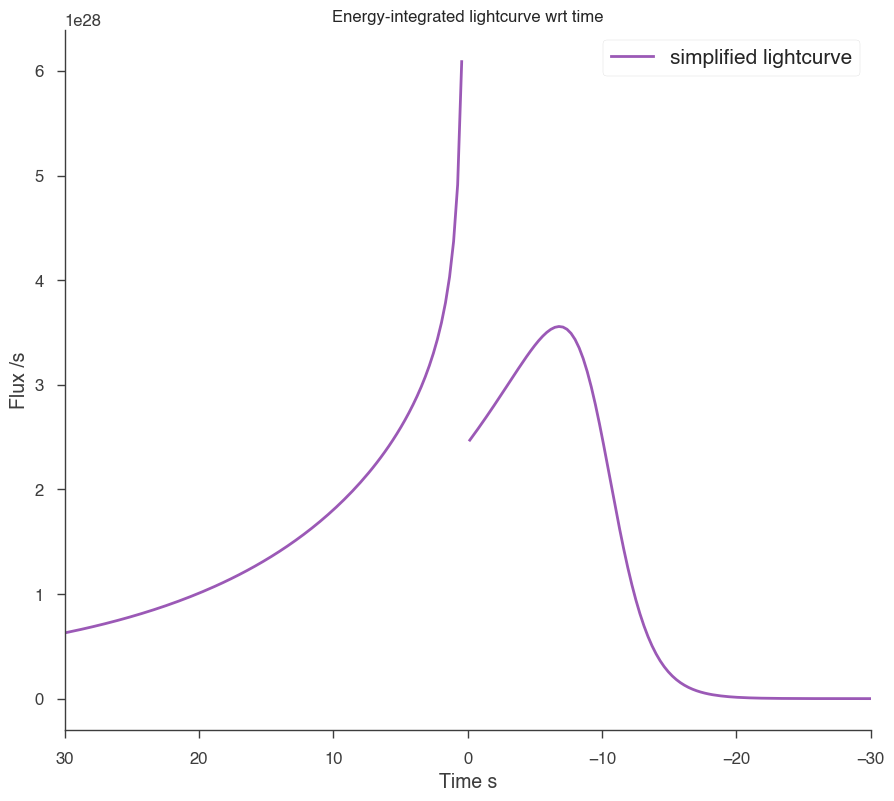

In [4]:
tau_s = np.linspace(30,0,100)
tau_a = np.linspace(30,-30,200)

s_curve = np.zeros(200)

fig, ax = plt.subplots()

s_curve[0:100] = lightcurve(tau_s,energy_range = np.linspace(Emin, Emax, 1000), normalization = 2*1e28)

a_curve = afterglow(tau_a, -10, 1.5, 14, 5*1e28)

ax.plot(tau_a, s_curve + a_curve, label = 'simplified lightcurve')

ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

### <a id="lightcurves" style="color:black;">Fitting the Lightcurves</a>
[back to top](#Top)

In [5]:
gbm_catalog = FermiGBMBurstCatalog()

In [47]:
def query_catalog(GRBNAME = '150902733', time_in = -30, time_out = 60, dt = .1, gbm_detectors = None):
    gbm_catalog.query_sources('GRB%s'%GRBNAME)

    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    
    if gbm_detectors is None:
        gbm_detectors = grb_info["detectors"]
    print(gbm_detectors)
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    dload = download_GBM_trigger_data('bn%s'%GRBNAME, detectors=gbm_detectors)

    fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        figures.append(ts_tte.view_lightcurve(time_in, time_out, dt = dt))
    return figures, gbm_detectors

import warnings
warnings.filterwarnings('ignore')

def get_curves(fig):
    data = fig.get_axes()[0].get_lines()[0].get_xydata()
    x = data[:,0]
    curve = data[:,1]
    
    bckg_data = fig.get_axes()[0].get_lines()[1].get_xydata()
    bckg_data = bckg_data[:,1]
    
    return x, curve, bckg_data

def show_curves(figures, detectors:list = np.arange(12), save_csv=None):
    figya, ax = plt.subplots()
    if save_csv is not None:
        assert type(save_csv) is str, 'Give a name to the file'
        assert detectors is not None, 'Just gimme the dets for cols'
        df = pd.DataFrame()
    for i,fig in enumerate(figures):
        x,curve, bckg = get_curves(fig)
        ax.plot(x,curve, label="det. %s"%detectors[i])
        ax.plot(x[0:-1],bckg, '--', label='bckg %s'%detectors[i])
        ax.legend(prop={'size':15})
        if save_csv is not None:
            df['time'] = x
            df[detectors[i]] = curve
            b = np.zeros(len(curve))
            b[0:len(bckg)] += bckg
            df['%s_bkg'%detectors[i]] = b
    if save_csv is not None:
        df.to_csv(save_csv)
    return figya

['n0' 'n1' 'n3' 'b0']


17:24:15 INFO      file glg_cspec_n0_bn150902733_v00.pha is already downloaded!           ]8;id=429767;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=48904;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn150902733_v02.rsp is already downloaded!           ]8;id=240618;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=227743;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:16 INFO      file glg_tte_n0_bn150902733_v00.fit is already downloaded!             ]8;id=572611;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=46283;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn150902733_v00.pha is already downloaded!           ]8;id=237694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=540666;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:17 INFO      file glg_cspec_n1_bn150902733_v02.rsp is already downloaded!           ]8;id=852432;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=244608;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn150902733_v00.fit is already downloaded!             ]8;id=818646;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=380906;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn150902733_v00.pha is already downloaded!           ]8;id=185590;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=560293;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:18 INFO      file glg_cspec_n3_bn150902733_v02.rsp is already downloaded!           ]8;id=227756;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=919003;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n3_bn150902733_v00.fit is already downloaded!             ]8;id=960001;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=114438;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:19 INFO      file glg_cspec_b0_bn150902733_v00.pha is already downloaded!           ]8;id=147223;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=359462;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150902733_v02.rsp is already downloaded!           ]8;id=986267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=98109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:20 INFO      file glg_tte_b0_bn150902733_v00.fit is already downloaded!             ]8;id=525841;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=474491;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:24:23 INFO      Auto-determined polynomial order: 1                                ]8;id=861963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=12608;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:24:41 INFO      None 1-order polynomial fit with the mle method                               ]8;id=55954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=804787;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=569718;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=40661;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=603841;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=266076;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=546664;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=430221;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for n0                                    ]8;id=399135;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=182085;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:24:46 INFO      Auto-determined polynomial order: 1                                ]8;id=7327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=825510;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:24:59 INFO      None 1-order polynomial fit with the mle method                               ]8;id=993217;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=740572;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=653042;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=383265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=640460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=275265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=565177;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=609433;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

17:25:00 INFO      Interval set to 3.84-17.408 for n1                                    ]8;id=417068;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=837161;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:25:04 INFO      Auto-determined polynomial order: 1                                ]8;id=48280;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=443961;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:25:14 INFO      None 1-order polynomial fit with the mle method                               ]8;id=564516;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=913045;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=352247;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=28589;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=30326;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=686906;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

17:25:15 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=265705;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=804134;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for n3                                    ]8;id=807124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=12358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:25:19 INFO      Auto-determined polynomial order: 1                                ]8;id=537052;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=824418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:25:30 INFO      None 1-order polynomial fit with the mle method                               ]8;id=864416;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=135650;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=376228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=801415;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=716354;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=209563;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

17:25:31 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=709973;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=103055;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for b0                                    ]8;id=495258;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=972401;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Maximum 8693.350706461864 at index 392, time 9.2
Maximum 8321.464903356951 at index 392, time 9.2
Maximum 9368.182837570457 at index 392, time 9.2
Maximum 7508.1787332614285 at index 392, time 9.2


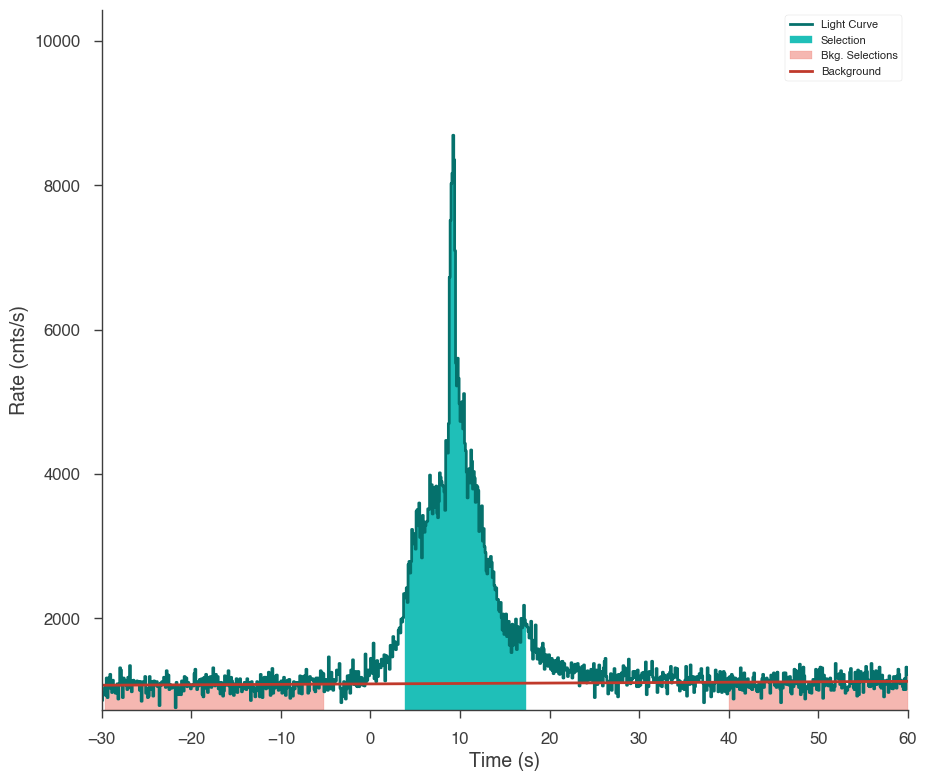

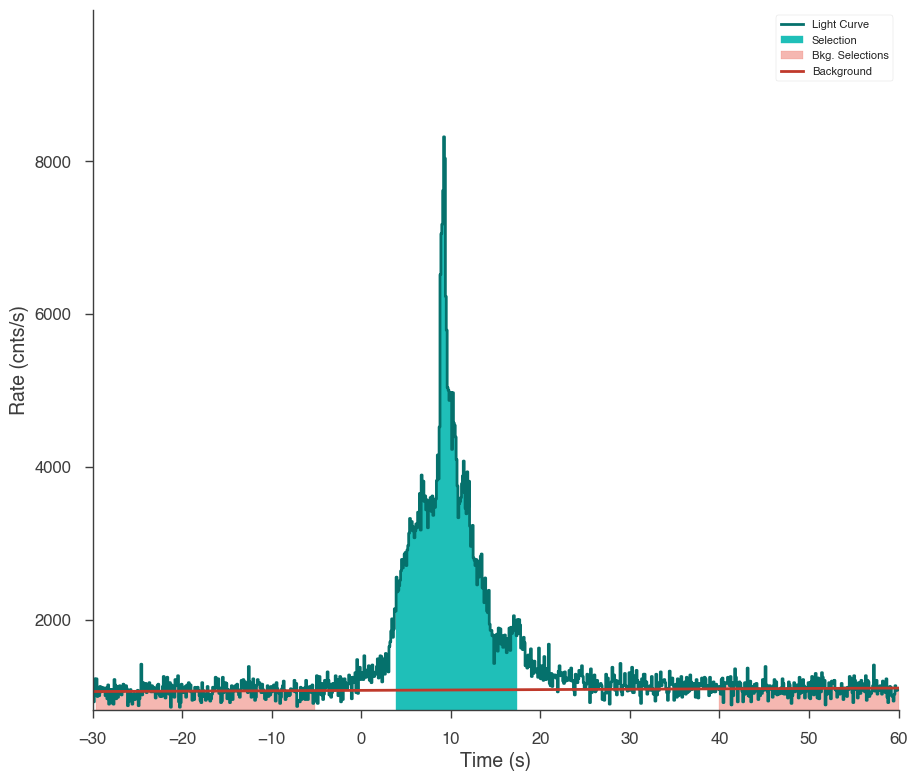

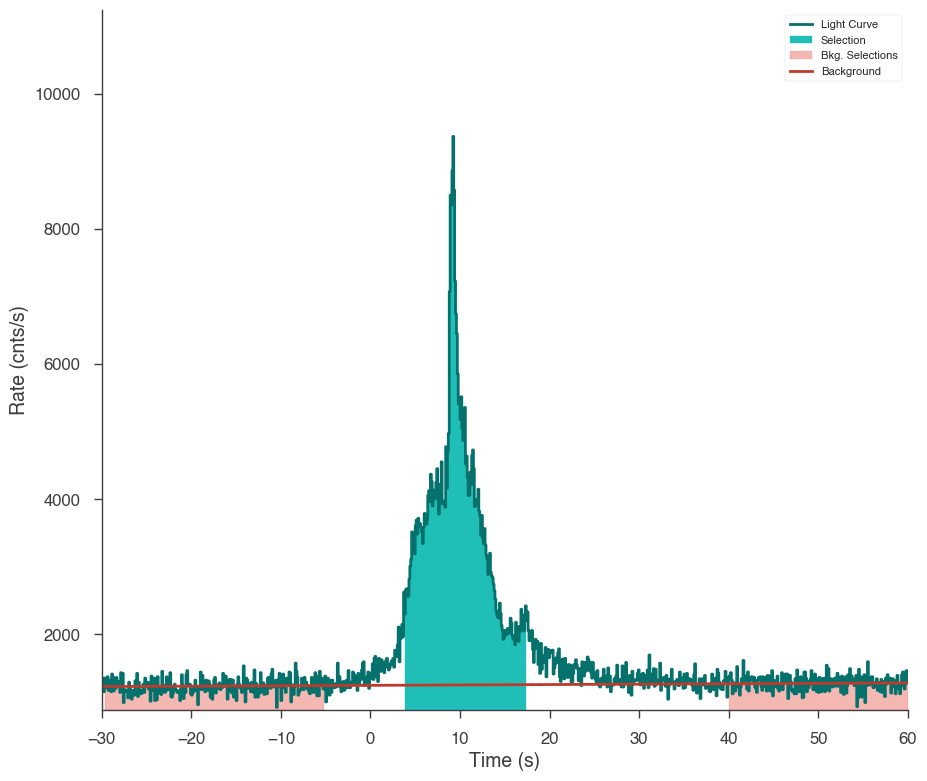

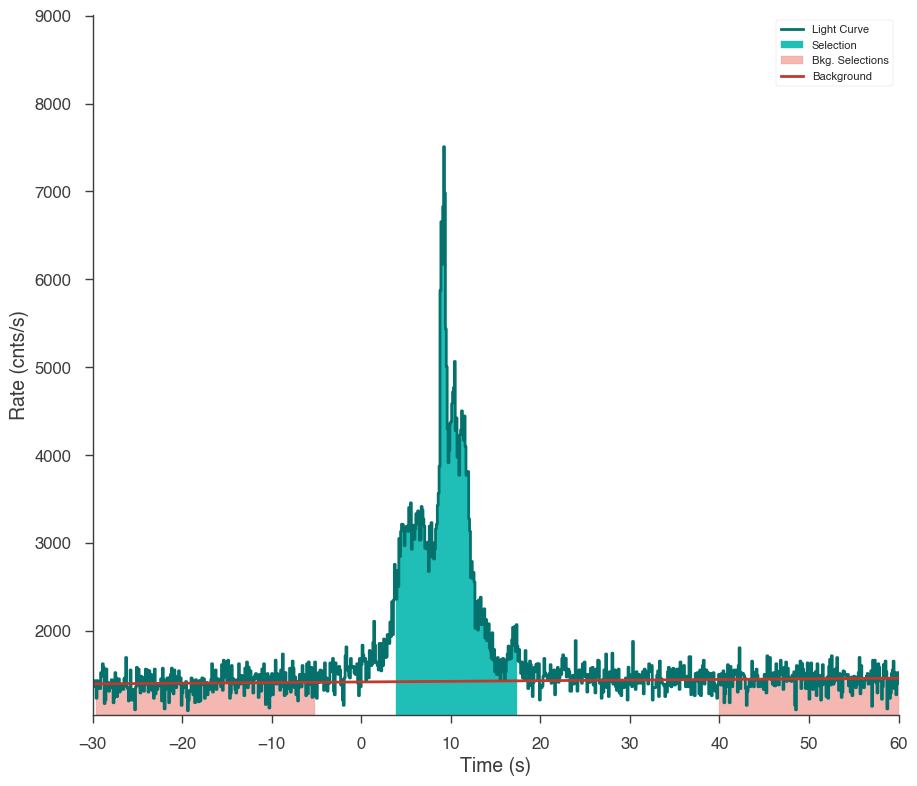

In [17]:
figures,dets = query_catalog(dt=.1)

"""
y = []
for fig in figures:
    x, curve, _ = get_curves(fig)
    print("Maximum %s at index %s, time %s"%(max(curve), 
                                             np.where(curve == max(curve))[0][0], 
                                             x[np.where(curve == max(curve))[0][0]]))
    y.append(curve)
"""

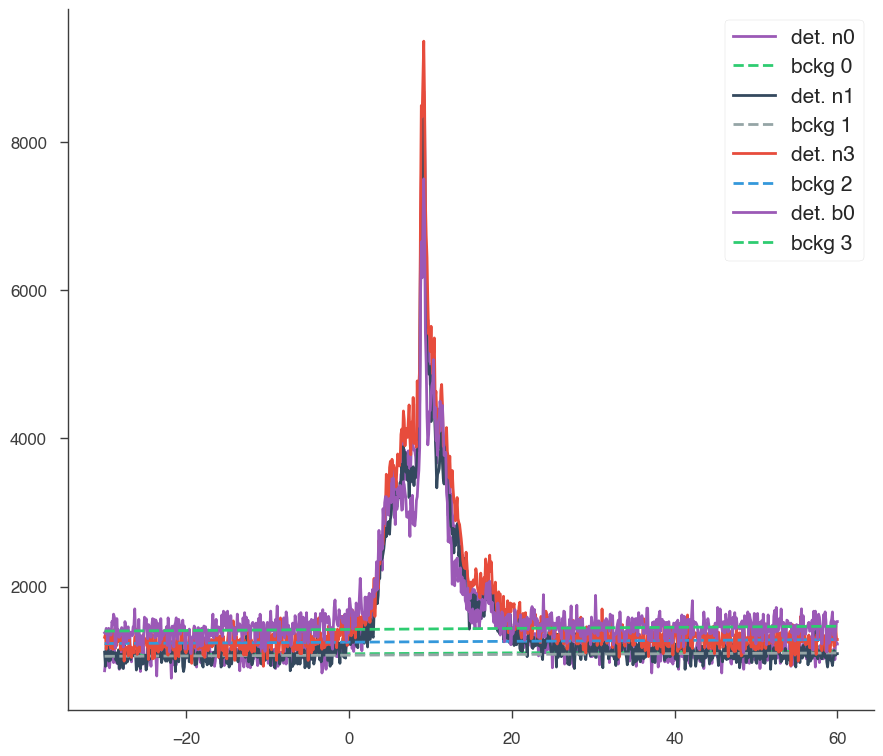

In [19]:
fig = show_curves(figures,dets)
fig.show()

In [53]:
def detector_data_to_DataFrame(figures, GRBNAME):
    
    gbm_catalog.query_sources('GRB%s'%GRBNAME)
    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    gbm_detectors = grb_info["detectors"]
    
    
    t = ['tau_' + item for item in gbm_detectors]
    bckg = [item + '_bckg' for item in gbm_detectors]
    
    data = pd.DataFrame()
        
    for i,fig in enumerate(figures):
        x, curve, bckg_data = get_curves(fig)
        
        data[t[i]]=pd.Series(x)
        data[gbm_detectors[i]] = pd.Series(curve)
        data[bckg[i]] = pd.Series(bckg_data)
    print('Saving to bn%s.csv'%GRBNAME)
    data.to_csv('bn%s.csv'%GRBNAME)
    
def retrieve_data(figures):
    y = None
    for fig in figures:
        x, curve, bckg_data = get_curves(fig)
        if y is None:
            y = curve-np.mean(bckg_data)
        else:
            y+=(curve-np.mean(bckg_data))
    return y/len(figures), x

Building our model to fit the lightcurve requires a couple components.

Firstly, the model needs to have one value per second interval to match the lightcurves. This will occupy the interval of the signal onset.

Second, we will want an afterglow ~ inverse powerlaw. This will be the interval following, showing the decay of the signal. We could start this decay from the maximum from the previous interval, but I think it's better to leave it open for now.
[Afterglow]()

Lastly there will be a background which contributes to the model evenly.

In [9]:
# Assemble the data
data, time_domain = retrieve_data(figures)
# This data is the curve averaged over detectors - background. All we need is the model.

# We want this to base the EBH lifetime.
peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

# Data error 
error_tolerance = np.mean(data) * 0.001

In [55]:
import ultranest

param_names = ['K_lightcurve', 'K_powerlaw', 't_m_powerlaw', 't_p_powerlaw', 
               'delta_powerlaw', 'index_lightcurve'] 

def lightcurve_model(K_lightcurve=None, K_powerlaw=None, 
        t_m_powerlaw=None, t_p_powerlaw=None, 
                     delta_powerlaw=None, index_lightcurve=None,
                     energy_range = np.linspace(Emin, Emax, 1000)):
    
    # Blank model
    model = np.zeros(len(data))

    if K_lightcurve is not None:
        # Descending from len(peak) -> 0 
        tau = np.linspace(peak_index, 0, peak_index, endpoint=False)
        # Simplified powerlaw curve
        curve = lightcurve(tau=tau, energy_range=energy_range, normalization=K_lightcurve, index = index_lightcurve)
        # Applied to [0,peak]
        model[0:peak_index]=curve
    
    if K_powerlaw is not None: 
        # Afterglow curve
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        # Applied across entire domain
        model = model + afterglow_curve

    return model

def likelihood_model(params):
    K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve = params
    
    curve = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    
    like = -0.5 * (((curve - data)/error_tolerance)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

def likelihood_model_only_direct(params):
    K_lightcurve, index_lightcurve = params
    curve = lightcurve_model(K_lightcurve, None, None, None, None, index_lightcurve)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()
    
def likelihood_model_only_afterglow(params):
    K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw = params
    curve = lightcurve_model(None, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, None)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()

def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3#1e-26
    hi = 1e6#1e-24
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [47]:
# Run fitting process
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+08  2e+08 [-2.234e+08..-2.234e+08]*| it/evals=34200/459327 eff=7.4522% N=400 
[ultranest] Likelihood function evaluations: 459327
[ultranest]   logZ = -2.234e+08 +- 0.229
[ultranest] Effective samples strategy satisfied (ESS = 2505.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.59, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.

logZ = -223374814.038 +- 0.392
  single instance: logZ = -223374814.038 +- 0.225
  bootstrapped   : logZ = -223374814.090 +- 0.392
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: 28219 iterations

    K_lightcurve        3374.28 +- 0.36
    K_powerlaw          7604.41 +- 0.15
    t_m_powerlaw        1.261831 +- 0.000034
    t_p_powerlaw        2.31333 +- 0.00014
    delta_powerlaw      9.6

In [56]:
def plot_model(x, result = None, log=False, name='bn150902733', vals=None, fig_text = None):
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(18)
    
    if result is not None:
        vals = result['posterior']['mean']
        std = result['posterior']['stdev']
    K_lightcurve = vals[0]
    K_powerlaw = vals[1]
    t_m_powerlaw = vals[2]
    t_p_powerlaw = vals[3]
    delta_powerlaw = vals[4]
    index_lightcurve = vals[5]
    
    ax1.scatter(x,data, s=30)
    ax2.scatter(x,data, s=30)
    
    fitted_model = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    r = pearsonr(data,fitted_model)
    ax1.plot(x, 
            fitted_model,
            label = 'r:%.4e  pval:%.4e'%(r[0],r[1]))
    
    if K_lightcurve is not None:
        curve = lightcurve(tau=np.linspace(peak_index, 0, peak_index, endpoint=False), 
                                  energy_range=np.linspace(Emin, Emax, 1000), 
                                  normalization=K_lightcurve)
        ax2.plot(x[0:peak_index], curve, label = 'simplified direct+frag emission')
    if K_powerlaw is not None:
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        ax2.plot(x, afterglow_curve, '--', label = r'afterglow $\frac{e^{Ax}}{1-e^{Bx}}$', color='orange')

    #plt.ylim(100,200)
    #ax2.ylim(-3500,6500)
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax1.set_ylabel('Count rate (per second, binned on .1s)')
    ax1.set_xlabel('Time wrt to trigger time')
    #ax2.set_ylabel('Count rate')
    ax2.set_xlabel('Time wrt to trigger time')
    fig.suptitle('Composite Bayesian fit of %s'%name, size=15)
    
    if fig_text is None:
        lc_txt="Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(vals[0], std[0], vals[5], std[5])
        pl_txt="Powerlaw norm: %.4e +- %.2e , t_m: %.4f +- %.2f , t_p: %.4f +- %.2f , delta: %.4f +- %.2f \n"%( 
            vals[1], std[1], vals[2], std[2], vals[3], std[3], vals[4], std[4] )
        fit_txt="logZ: %.4e +- %.2e (Z = marginal likelihood)"%(result['logz'], result['logzerr'])
        fig_text = lc_txt + pl_txt + fit_txt
    
    plt.figtext(0.5, 0.01, fig_text, wrap=True, horizontalalignment='center', fontsize=13)
    
    if log:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    return fig

#fig = plot_model(time_domain,result = result, log=False)


### <a id="candidates" style="color:black;">Expanding to other sources</a>
[back to top](#Top)

- [bn091031500](#09)
- [bn140206275](#14)
- bn150902733 was done in the example
- [bn150118409](#15)
- [bn160821857](#16)
- [bn180718763](#18)
- [bn190731943](#19)

The main difference in fitting between sources is the parameter bounds for normalization. This is why we expand them below here.

Mostly thinking 14,16,19

#### <a id="09" style="color:black;">bn0901031500</a>

- tau = [ -30 , 60 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_09(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 10
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="14" style="color:black;">bn140206275</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n0' 'n1' 'n3' 'b0']


Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:25 INFO      Auto-determined polynomial order: 1                                ]8;id=795531;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=843627;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:36 INFO      None 1-order polynomial fit with the mle method                               ]8;id=433162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=815307;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=837358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=811653;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=906184;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=712605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:38:38 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=87276;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=767406;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n0                                  ]8;id=515466;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=126060;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:44 INFO      Auto-determined polynomial order: 3                                ]8;id=996689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=209696;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:59 INFO      None 3-order polynomial fit with the mle method                               ]8;id=917722;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=568096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=759915;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=181019;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=991988;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=659702;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:00 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=559867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=150631;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n1                                  ]8;id=407795;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=314334;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:07 INFO      Auto-determined polynomial order: 3                                ]8;id=616537;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=807000;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:21 INFO      None 3-order polynomial fit with the mle method                               ]8;id=581360;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=254567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=450762;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=551231;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=586871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=988704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:22 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=380182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=584288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

21:39:23 INFO      Interval set to 7.488-154.178 for n3                                  ]8;id=359322;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=616834;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:29 INFO      Auto-determined polynomial order: 1                                ]8;id=792397;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=888759;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:41 INFO      None 1-order polynomial fit with the mle method                               ]8;id=466377;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=843166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=342186;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=780600;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=616879;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=802486;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:42 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=141155;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=108120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for b0                                  ]8;id=916903;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=23499;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

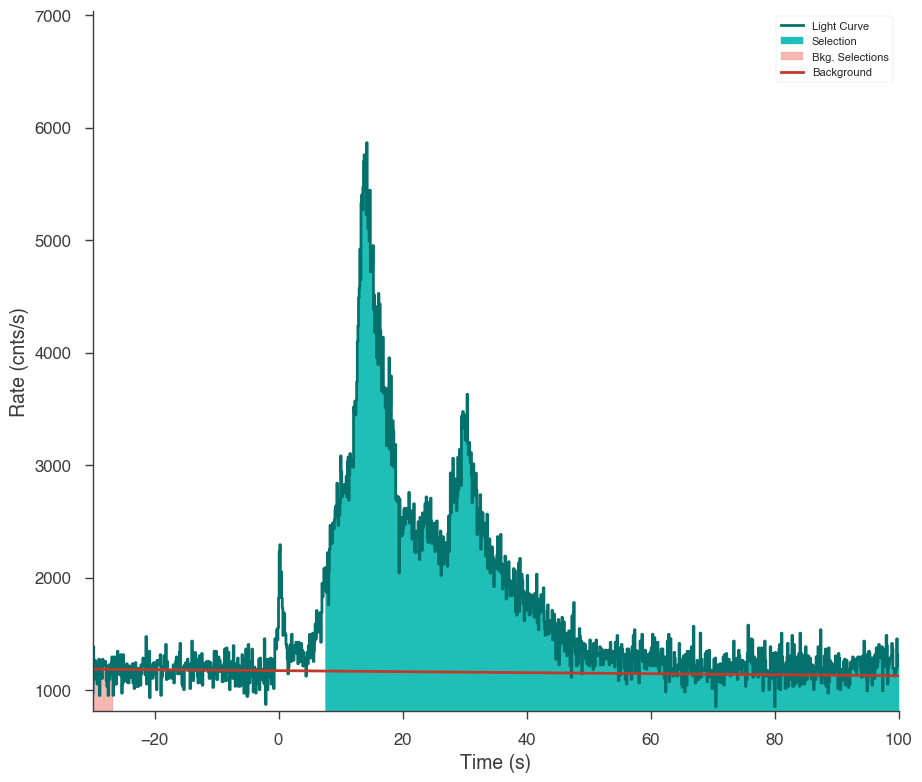

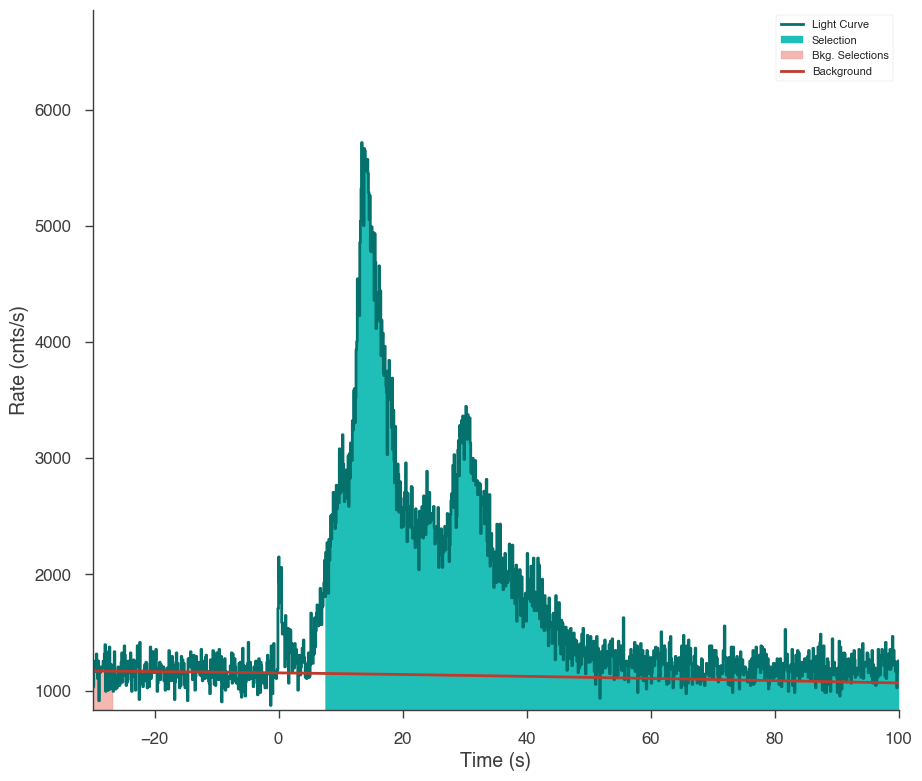

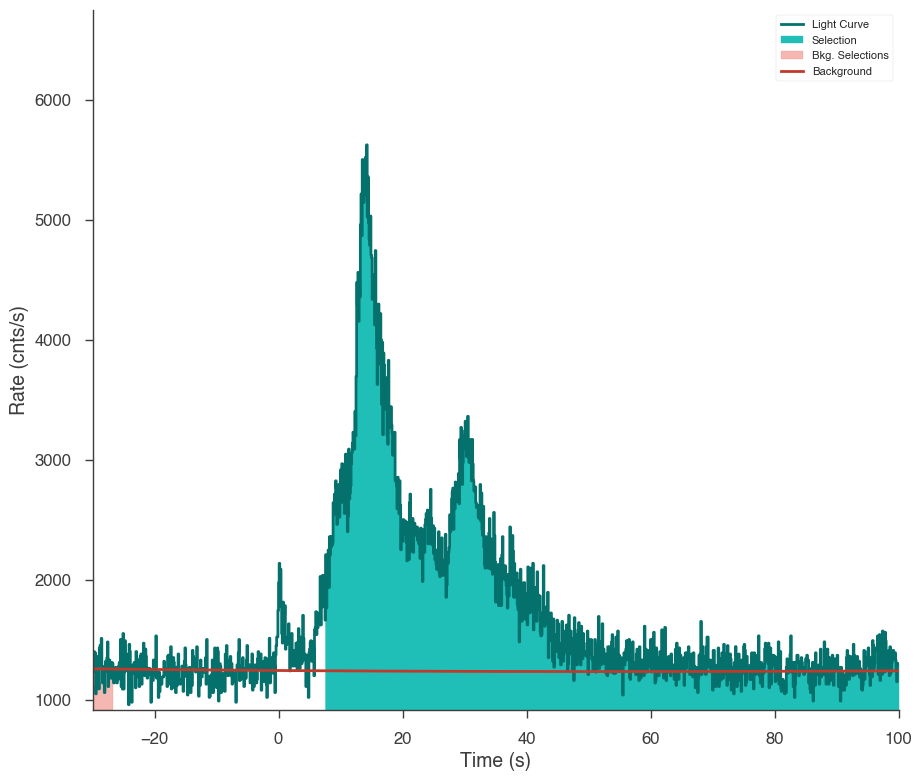

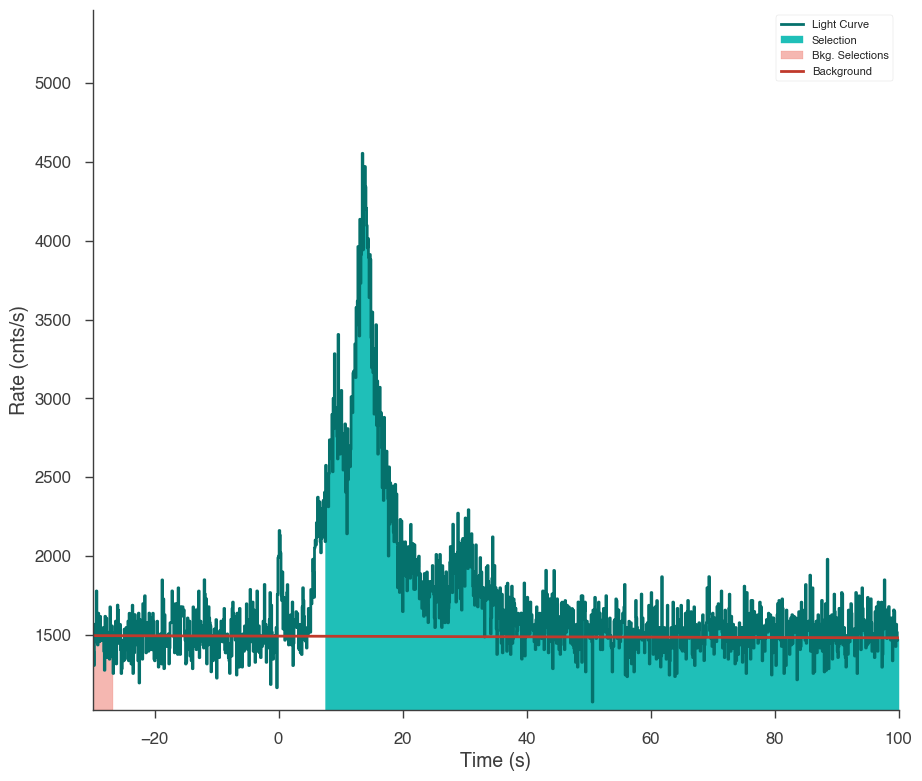

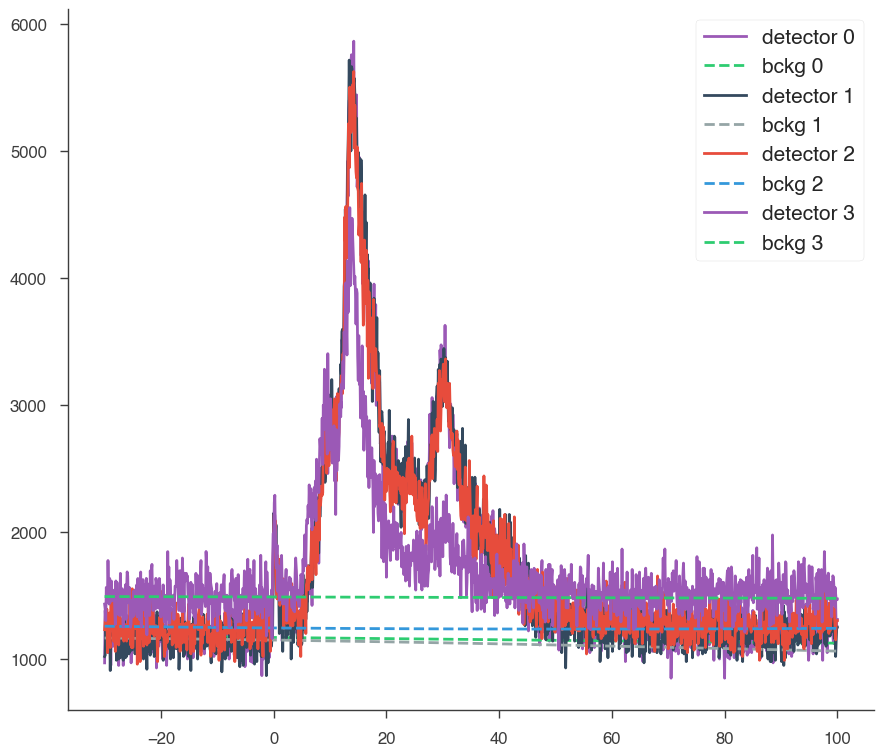

In [40]:
figures = query_catalog(GRBNAME = '140206275', time_in = -30, time_out = 100,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [41]:
def prior_transform_14(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 439
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  899.88 [-1900.2733..-1900.2719]*| it/evals=17600/282066 eff=6.2485% N=400    00 0 
[ultranest] Likelihood function evaluations: 282136
[ultranest]   logZ = -1940 +- 0.2027
[ultranest] Effective samples strategy satisfied (ESS = 2494.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.16 to 0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -1939.631 +- 0.507
  single instance: logZ = -1939.631 +- 0.303
  bootstrapped   : logZ = -1939.638 +- 0.507
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1483  │ ▁▁▁▁▁▁▁▁▂▂▃▃▄▅▇▇▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁  ▁ │2521      1970 +- 122
    K_powerlaw          : 3308  │ ▁▁ ▁▁▁▁▁▁▁▁▂▂▃▃▅▆▆▆▇▆▅▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │3640     

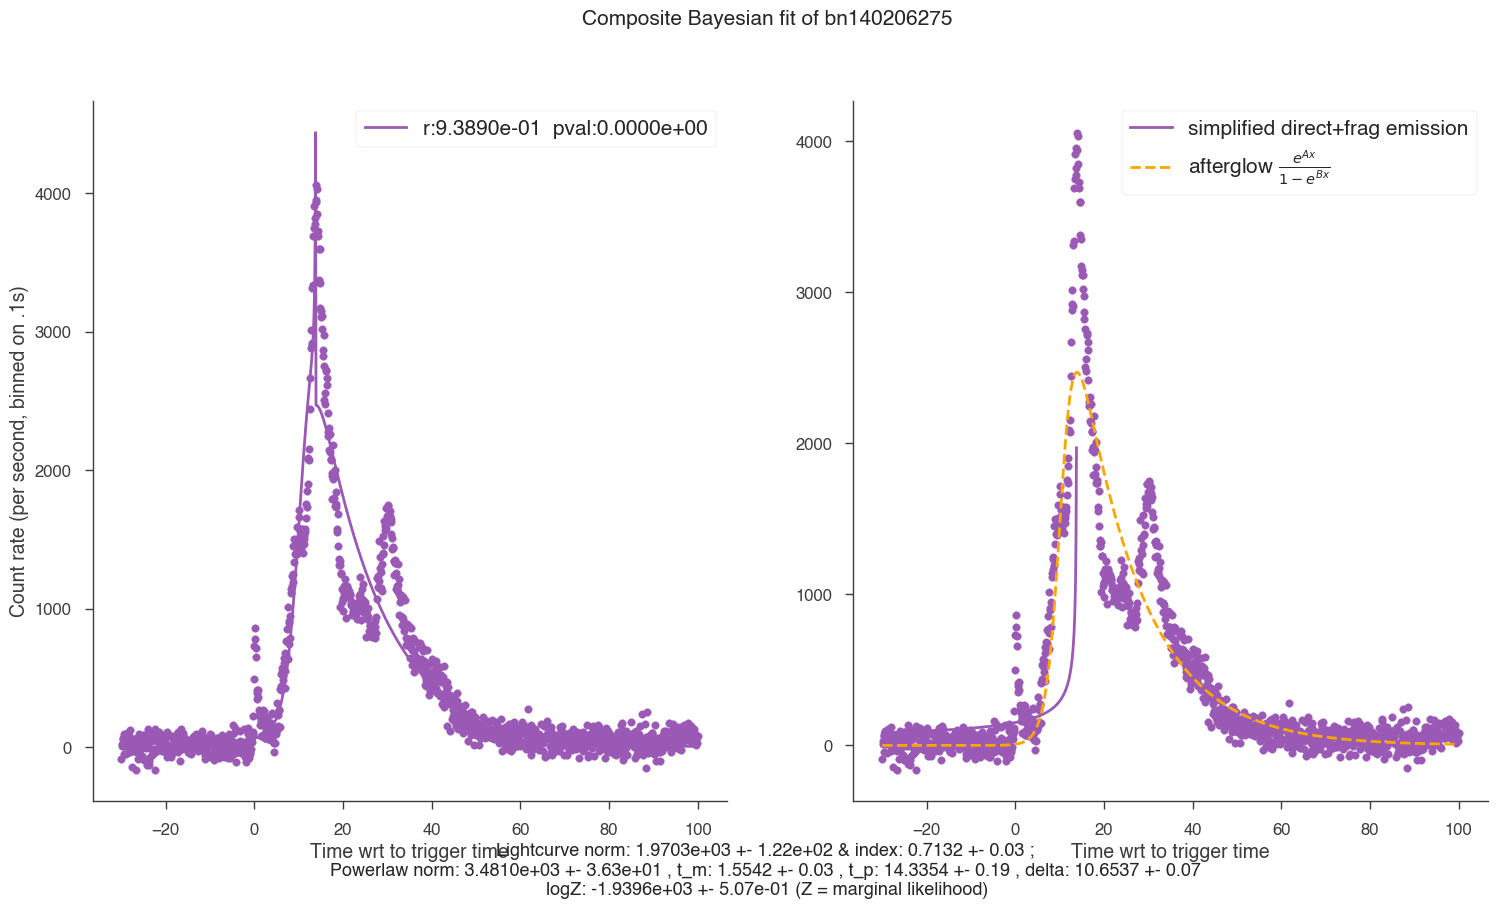

In [43]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_14)

result14 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result14, log=False, name = 'bn140206275')

[back to candidates](#candidates)

#### <a id="15" style="color:black;">bn150118409</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_15(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="16" style="color:black;">bn160821857</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 1e3 , 1e7 ]
- K_powerlaw = [ 1 , 1e6 ]

In [ ]:
figures = query_catalog(GRBNAME = '160821857', time_in = 100, time_out = 200,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [25]:
def prior_transform_16(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 5*1e3
    hi = 1e6
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e5
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = 100
    hi = 180
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 357
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  352.07 [-1352.5601..-1352.5600]*| it/evals=20120/1321167 eff=1.5234% N=400   0   0  0 
[ultranest] Likelihood function evaluations: 1321182
[ultranest]   logZ = -1398 +- 0.245
[ultranest] Effective samples strategy satisfied (ESS = 2743.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.19 to 0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.33 bs:0.24 tail:0.01 total:0.25 required:<0.50
[ultranest] done iterating.

logZ = -1398.111 +- 0.542
  single instance: logZ = -1398.111 +- 0.326
  bootstrapped   : logZ = -1398.123 +- 0.542
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 5000  │▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │5451      5050 +- 48
    K_powerlaw          : 19790 │ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ │20693 

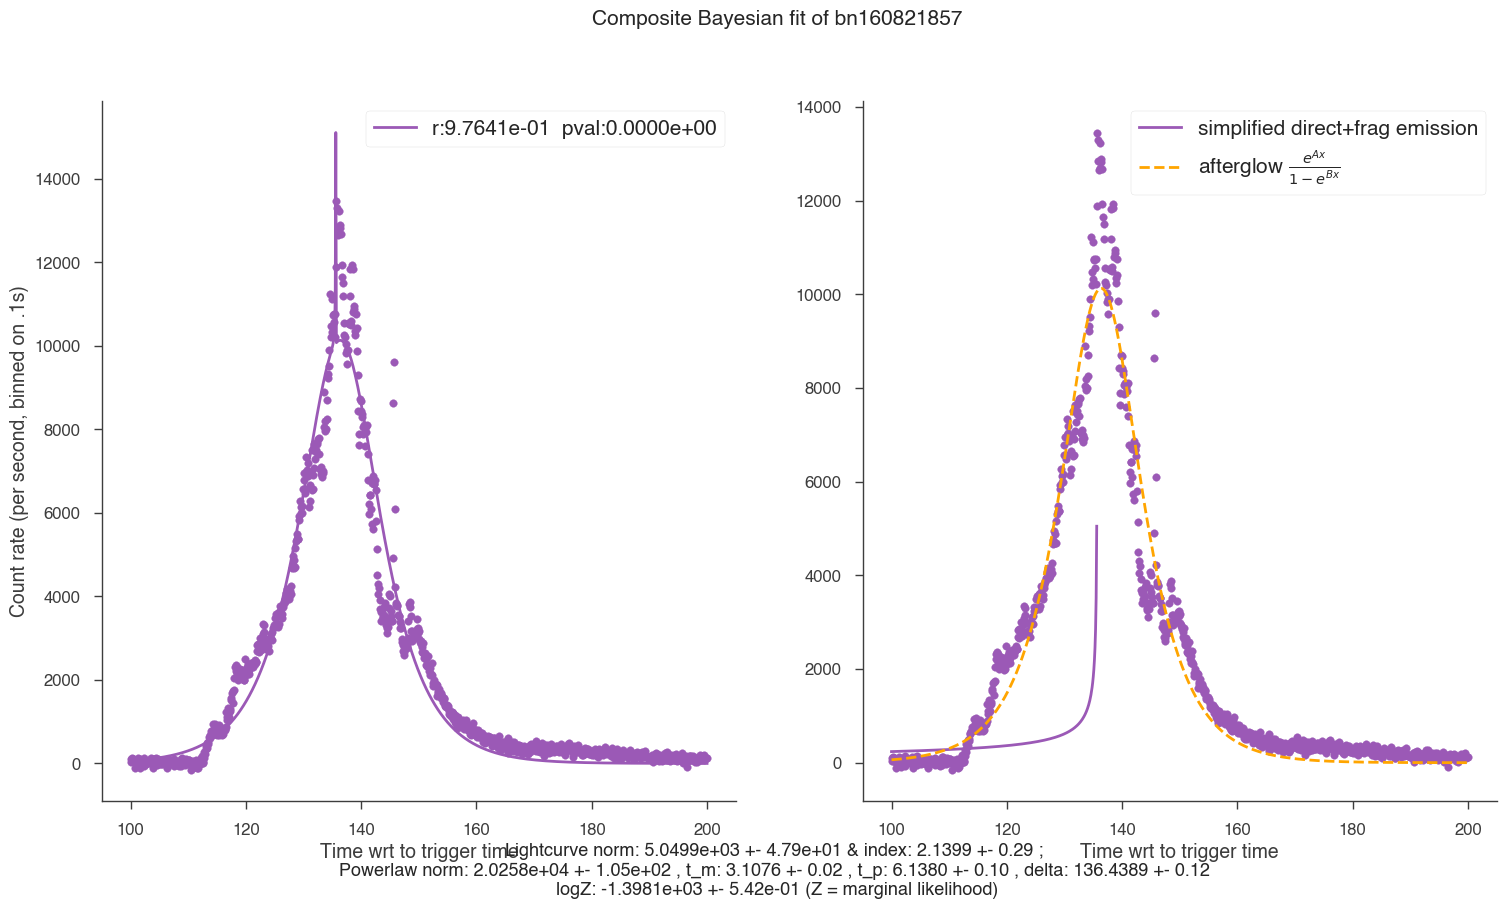

In [33]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_16)

result16 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result16, log=False, name = 'bn160821857')

[back to candidates](#candidates)

#### <a id="18" style="color:black;">bn180718763</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_18(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e7
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e6
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="19" style="color:black;">bn190731943</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1']


19:59:06 INFO      file glg_cspec_n6_bn190731943_v00.pha is already downloaded!           ]8;id=666209;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=572643;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:07 INFO      file glg_cspec_n6_bn190731943_v02.rsp2 is already downloaded!          ]8;id=591674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=837856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn190731943_v00.fit is already downloaded!             ]8;id=878168;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=382870;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:08 INFO      file glg_cspec_n7_bn190731943_v00.pha is already downloaded!           ]8;id=585214;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=869238;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn190731943_v02.rsp2 is already downloaded!          ]8;id=529963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=821688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n7_bn190731943_v00.fit is already downloaded!             ]8;id=956811;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=808684;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:09 INFO      file glg_cspec_n8_bn190731943_v00.pha is already downloaded!           ]8;id=505566;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=357430;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n8_bn190731943_v02.rsp2 is already downloaded!          ]8;id=264341;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=846744;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:40 INFO      Auto-determined polynomial order: 0                                ]8;id=555291;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=194057;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:00:52 INFO      None 0-order polynomial fit with the mle method                               ]8;id=401438;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=982543;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=573091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=259274;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

20:00:53 INFO      Saved background to n6_bkg.h5                                         ]8;id=408226;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=57128;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=66976;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=394933;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n6                                   ]8;id=393246;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=625908;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:57 INFO      Auto-determined polynomial order: 0                                ]8;id=880850;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=806789;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=68267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=272444;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=655256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=450752;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=182190;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=934474;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=465465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=681041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:11 INFO      Interval set to 1.792-17.664 for n7                                   ]8;id=916731;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=337867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:16 INFO      Auto-determined polynomial order: 0                                ]8;id=711435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=658853;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_08 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:29 INFO      None 0-order polynomial fit with the mle method                               ]8;id=566460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=239548;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n8_bkg.h5                                         ]8;id=22173;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=910690;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n8_bkg.h5                                         ]8;id=238365;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=761162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n8_bkg.h5                              ]8;id=147109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=180948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:30 INFO      Interval set to 1.792-17.664 for n8                                   ]8;id=946942;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=653560;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:33 INFO      Auto-determined polynomial order: 0                                ]8;id=489814;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=768930;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:45 INFO      None 0-order polynomial fit with the mle method                               ]8;id=926462;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=321912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=489938;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=305729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=903578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=762200;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:01:46 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=839097;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=456413;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n9                                   ]8;id=443775;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=203400;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:49 INFO      Auto-determined polynomial order: 0                                ]8;id=558612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=671965;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:01 INFO      None 0-order polynomial fit with the mle method                               ]8;id=651970;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=36506;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=981567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=493756;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=489509;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=353555;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from na_bkg.h5                              ]8;id=808418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:02:02 INFO      Interval set to 1.792-17.664 for na                                   ]8;id=883110;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:06 INFO      Auto-determined polynomial order: 0                                ]8;id=329440;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=228667;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_11 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:19 INFO      None 0-order polynomial fit with the mle method                               ]8;id=668688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=451285;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to nb_bkg.h5                                         ]8;id=275833;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=768305;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to nb_bkg.h5                                         ]8;id=814385;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=338382;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from nb_bkg.h5                              ]8;id=135183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=243637;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for nb                                   ]8;id=71020;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=567824;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:24 INFO      Auto-determined polynomial order: 0                                ]8;id=633602;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=442250;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:38 INFO      None 0-order polynomial fit with the mle method                               ]8;id=195374;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=157112;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=143130;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=319279;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=833228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=942576;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:02:39 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=118927;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=780516;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for b1                                   ]8;id=549120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=307809;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

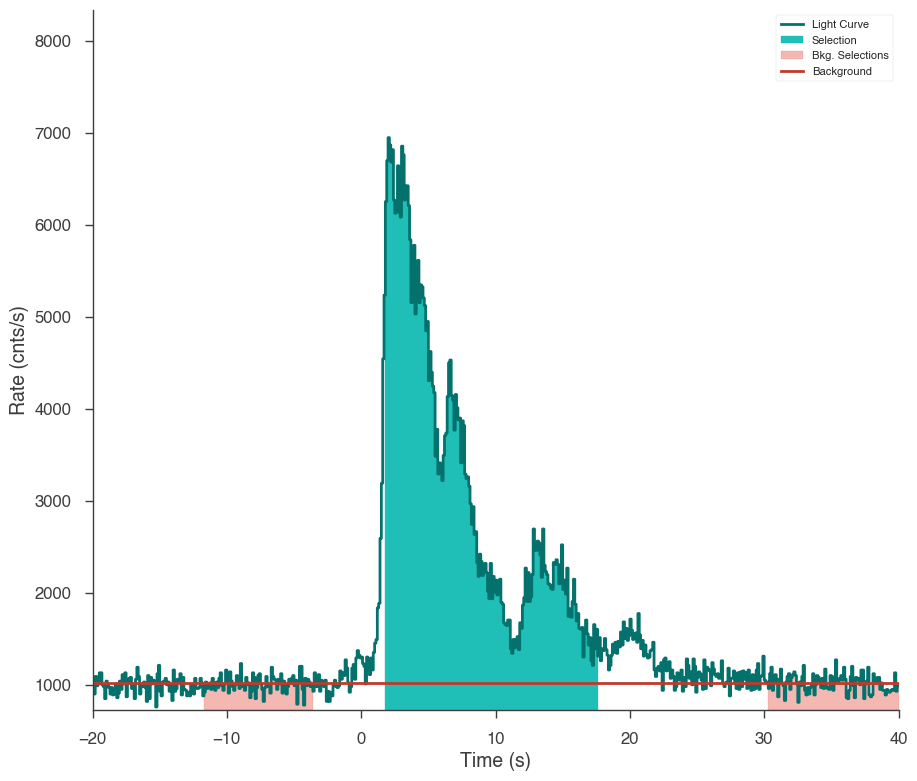

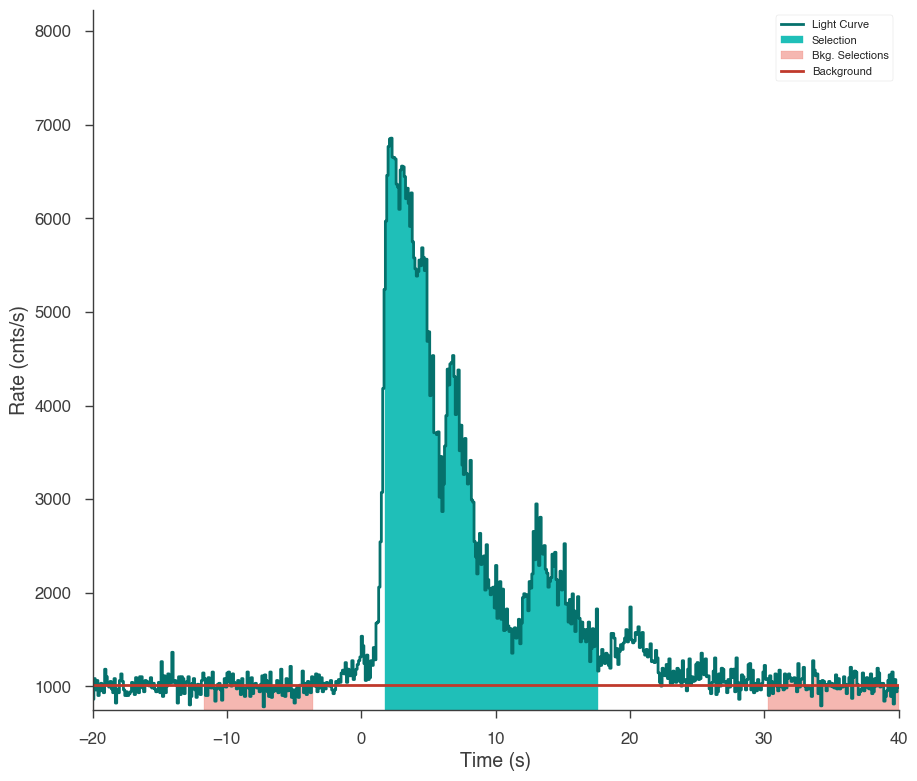

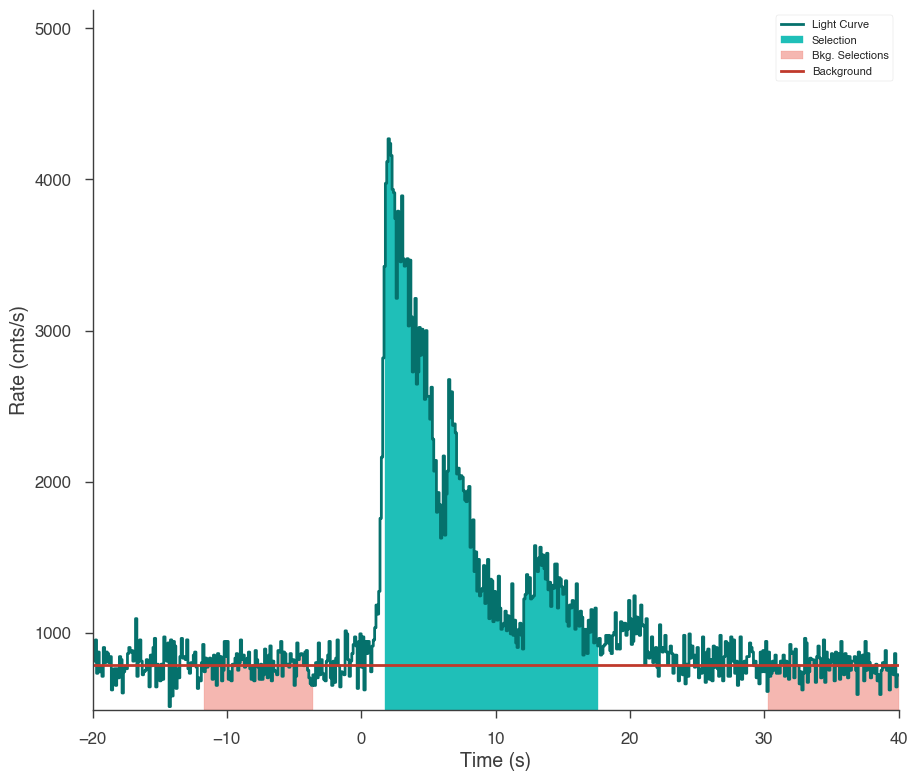

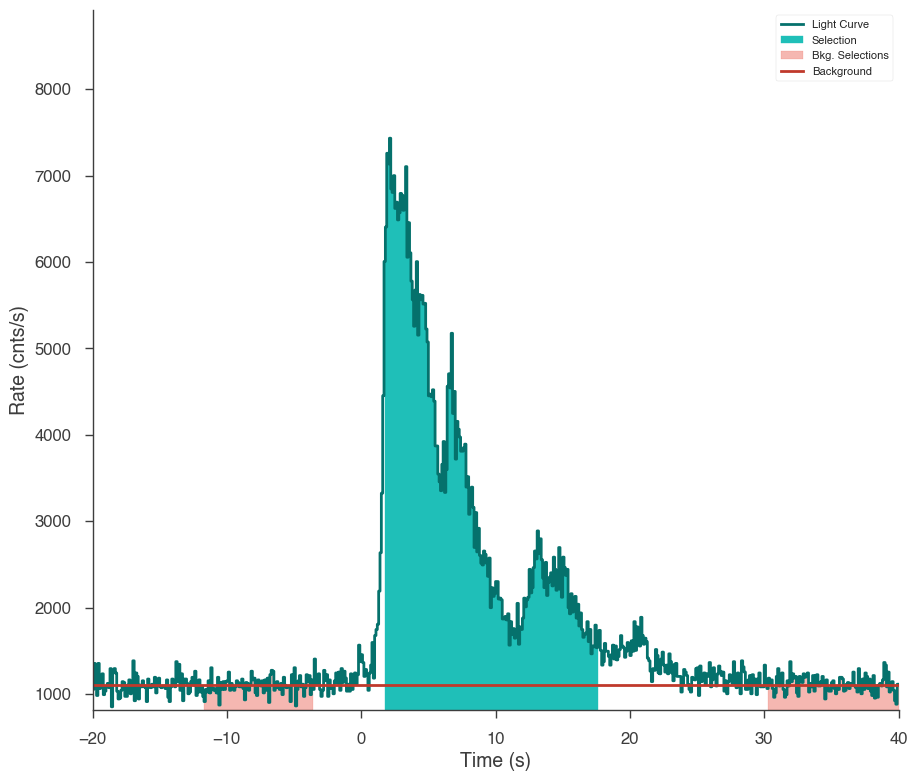

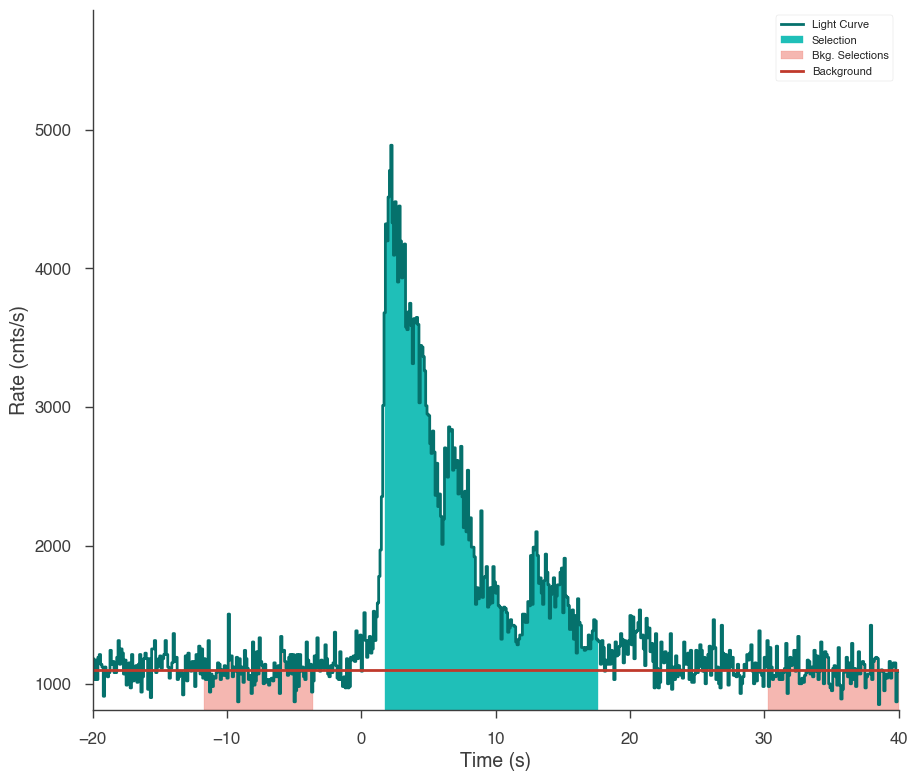

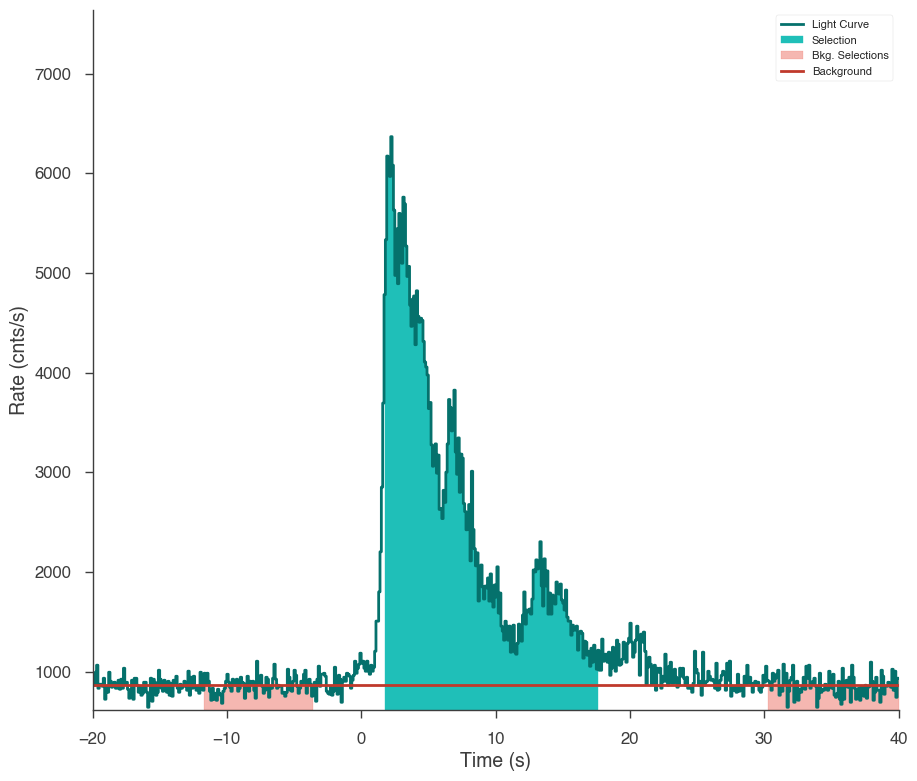

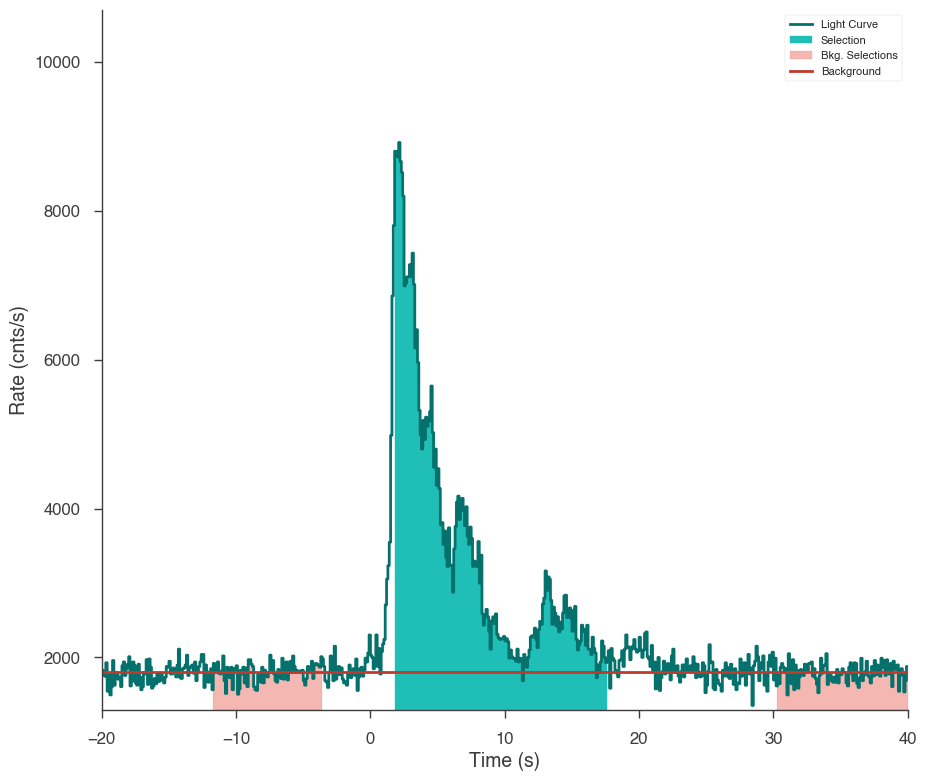

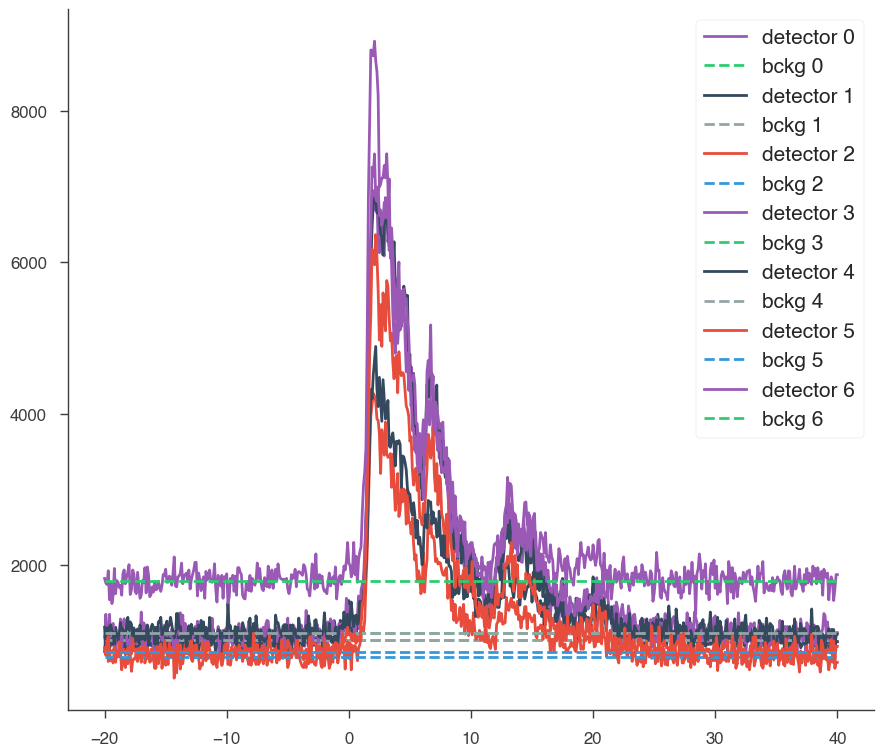

In [35]:
figures = query_catalog(GRBNAME = '190731943', time_in = -20, time_out = 40,dt=.1, gbm_detectors = ['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1'])

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [26]:
def prior_transform_19(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [38]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_19)

result19 = sampler.run()
sampler.print_results()

Peak index at 221
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .83 [-141.3571..-141.3558]*| it/evals=17600/470757 eff=3.7418% N=400    00 0 
[ultranest] Likelihood function evaluations: 470866
[ultranest]   logZ = -180.6 +- 0.1965
[ultranest] Effective samples strategy satisfied (ESS = 2586.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -180.653 +- 0.460
  single instance: logZ = -180.653 +- 0.302
  bootstrapped   : logZ = -180.648 +- 0.460
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1000  │▇▆▅▅▄▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │1962      1130 +- 117
    K_powerlaw          : 5464  │ ▁ ▁▁▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │6355      5902 +- 101
    t_m_powerlaw        

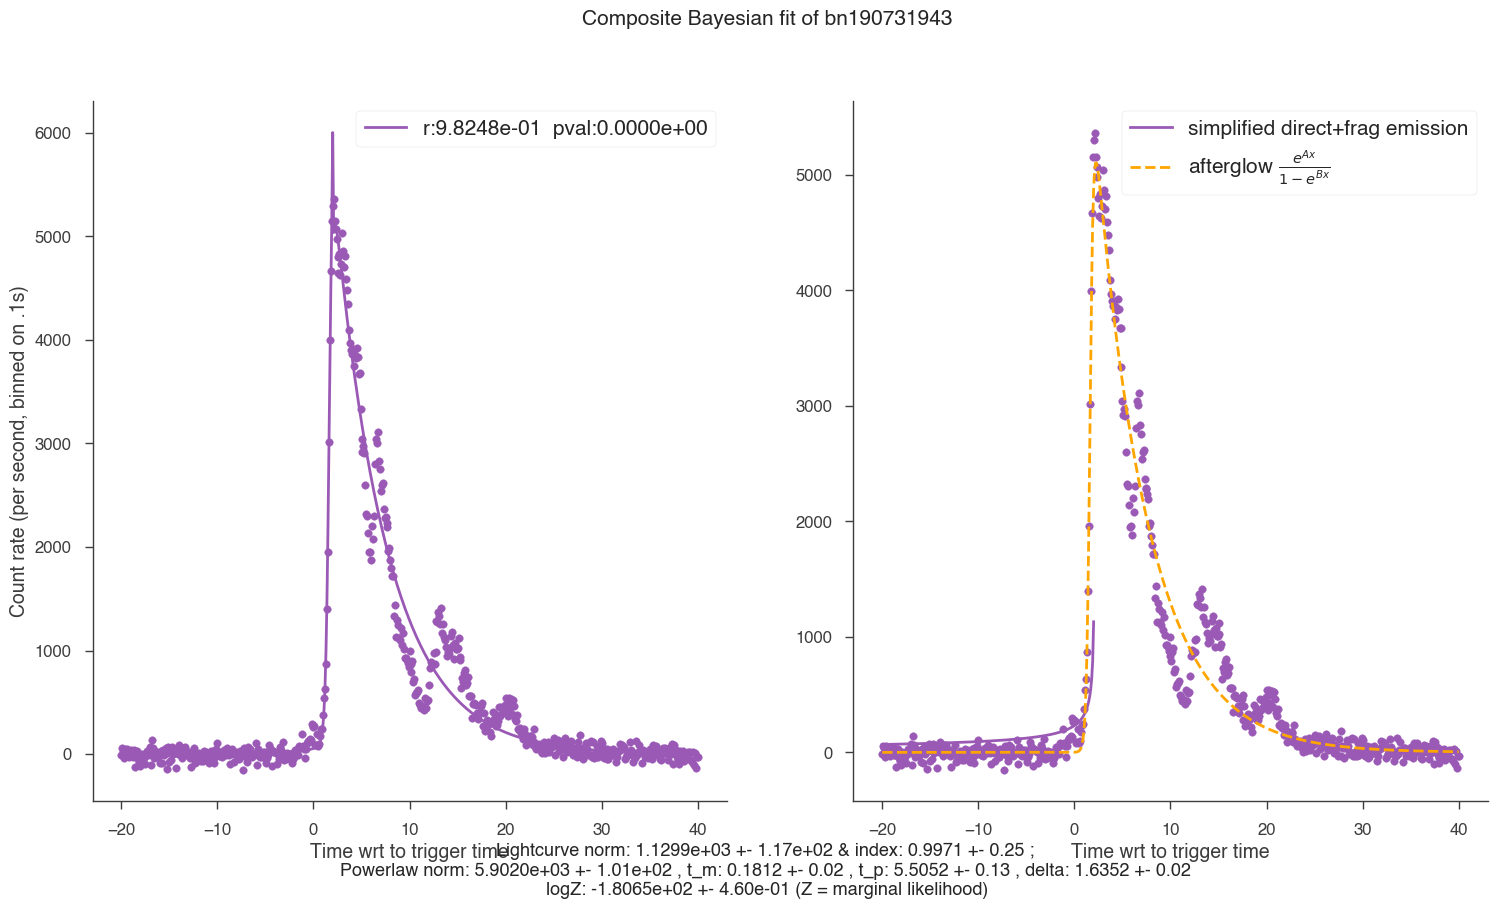

In [39]:
fig = plot_model(time_domain, result = result19, log=False, name='bn190731943'

Miscellaneous possible candidates

- 180305393 (Weirdly high error)

- 131216081
- 121225417
- 150416773
- 160101215

Top short burst duration

- 090531775
- 130310840
- 160325291

S-bursts
- bn110728056
- bn141113346
- bn090228204 : time_in=-.5, time_out=1

['n9']


03:32:06 INFO      file glg_cspec_n9_bn130310840_v00.pha is already downloaded!           ]8;id=546077;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=302225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn130310840_v03.rsp is already downloaded!           ]8;id=822513;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=171863;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:32:07 INFO      file glg_tte_n9_bn130310840_v00.fit is already downloaded!             ]8;id=977921;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=676357;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1854 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

03:32:10 INFO      Auto-determined polynomial order: 0                                ]8;id=799622;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=317703;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

03:32:22 INFO      None 0-order polynomial fit with the mle method                               ]8;id=236388;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=20192;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=688154;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=534488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=582310;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=248407;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=476640;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=425196;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 4.096-20.096 for n9                                   ]8;id=974628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=768039;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

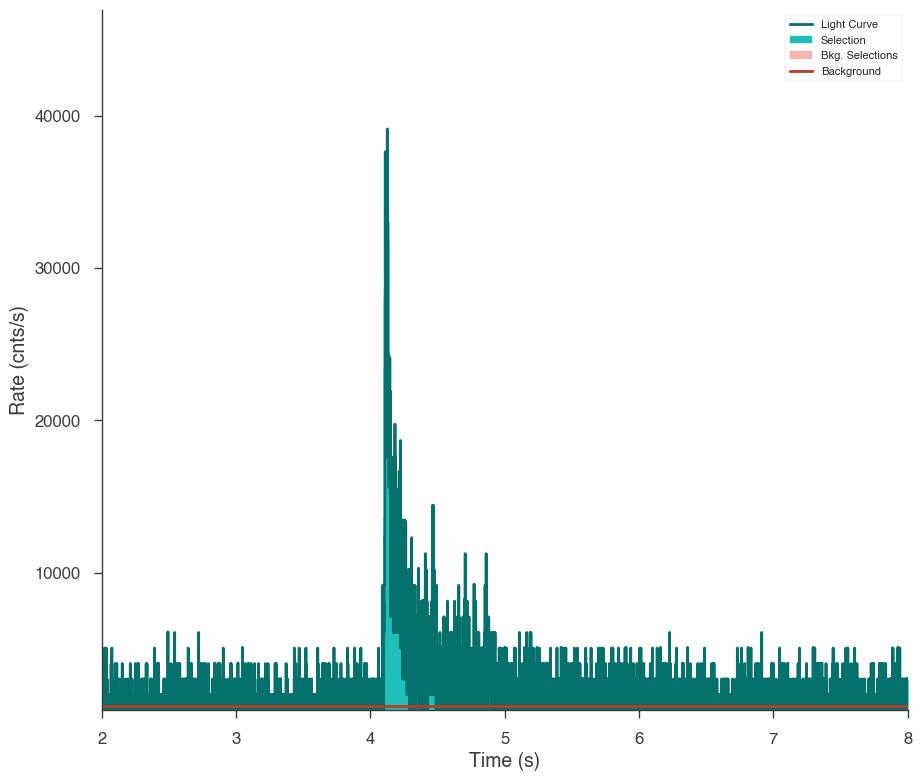

In [14]:
GRBNAME = '130310840'

figures = query_catalog(GRBNAME = GRBNAME, 
                        time_in = 2, time_out = 8, dt=1e-3,
                        gbm_detectors = ['n9'])

Text(0.5, 0, 's')

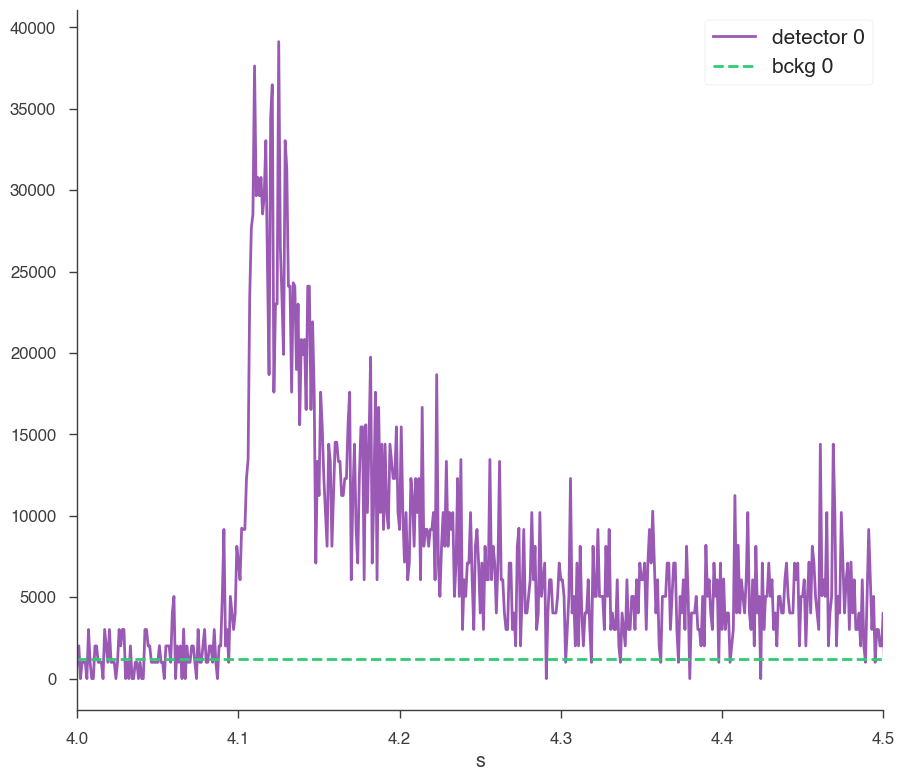

In [15]:
fig = show_curves(figures)
ax = fig.get_axes()[0]
ax.set_xlim(4,4.5)
ax.set_xlabel('s')
# Looks quite similar to Figure 5 in the Cline '97 paper

In [33]:
def prior_transform_13(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo
    """
    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    """
    # index_lightcurve: gaussian on -.52 
    params[1] = norm.ppf(cube[1], -.52, 1)
    
    return params

data, time_domain = retrieve_data(figures)

In [34]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = 1e2#np.std(bckg_data)
print('Using error tolerance of %3e'%error_tolerance)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler([param_names[0], param_names[-1]],
                                          likelihood_model_only_direct, prior_transform_13)

result19 = sampler.run()
sampler.print_results()

Using error tolerance of 1.000000e+02
Peak index at 2125
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+06  91..-2297783.90 [-2297783.9135..-2297783.9135]*| it/evals=7840/10603 eff=76.8401% N=400 
[ultranest] Likelihood function evaluations: 10617
[ultranest]   logZ = -2.298e+06 +- 0.1394
[ultranest] Effective samples strategy satisfied (ESS = 1590.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -2297798.935 +- 0.342
  single instance: logZ = -2297798.935 +- 0.187
  bootstrapped   : logZ = -2297798.947 +- 0.342
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 47352 │ ▁▁▁▁▁▁▁▁▂▃▃▄▆▅▅▆▆▇▇▆▅▅▃▃▂▁▂▁▁▁▁▁▁▁▁ ▁ │47913     47610 +- 70
    index_lightcurve    : 0.69056│ ▁▁▁▁▁▁▁▁▁▂▂▂▃▄▆▅▆▇▇▇▇▆▇▅▄▄▂▂▂▁▁▁▁▁▁▁▁ │0.69469    0.69272 

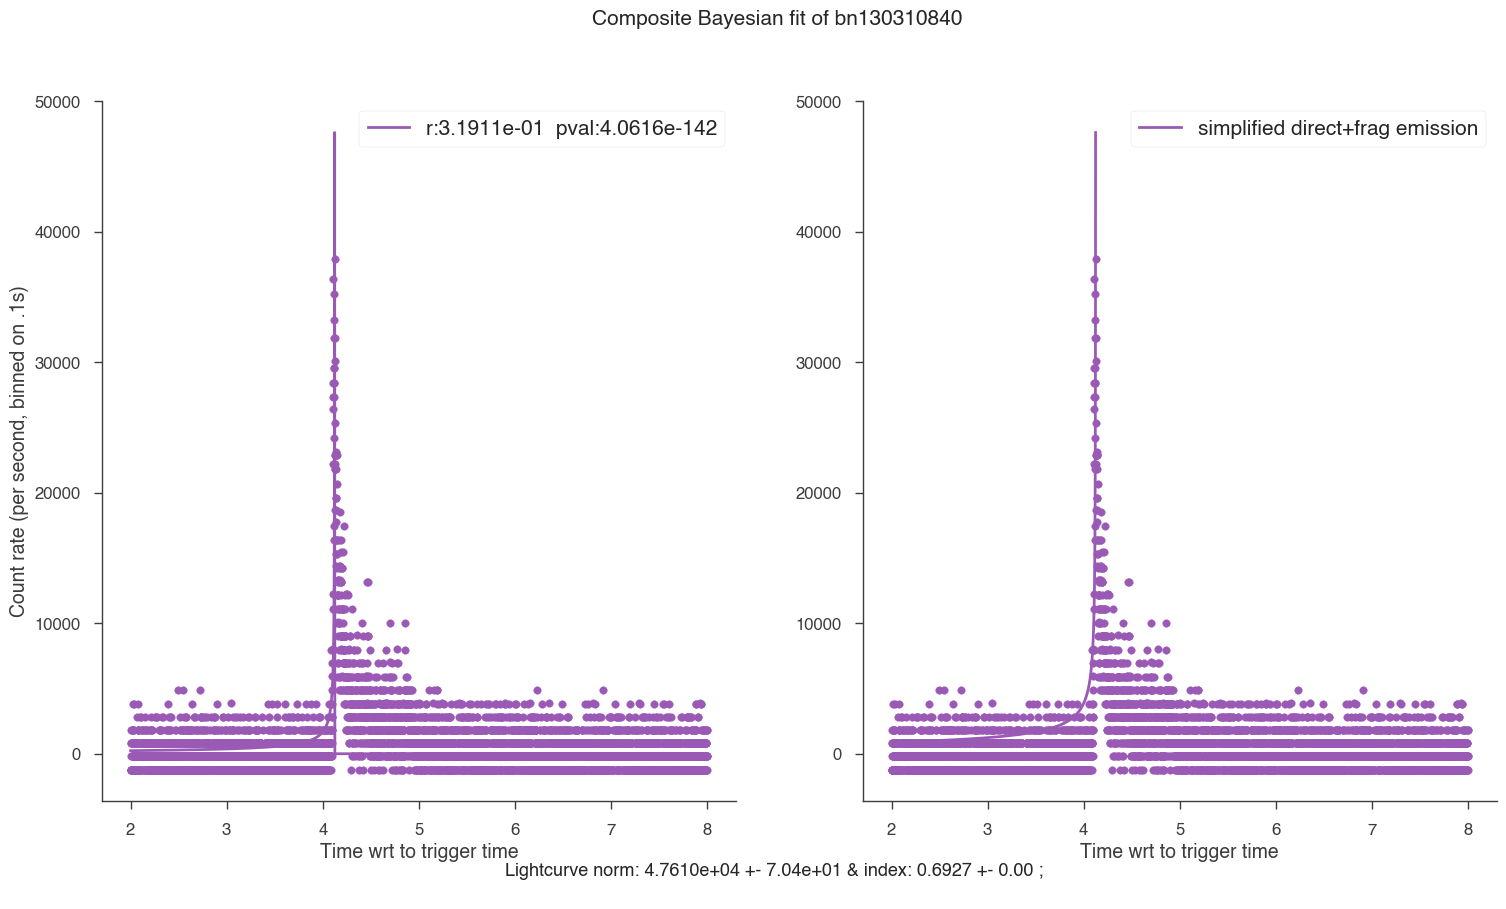

In [52]:
v = result19['posterior']['mean']
s = result19['posterior']['stdev']
fig = plot_model(time_domain, vals = [v[0], None, None, None, None, v[1]], log=False, name='bn130310840',
                fig_text = "Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(v[0], s[0], v[1], s[1]))


### <a id="batchfit2s" style="color:black;">Batch fit all sources with a GBM or LLE t90<2s </a>
[back to top](#Top)

In [26]:
selection = pd.read_csv('./GBM_Catalog_Searching/Single_bin_<2s_sources.csv')

cols = ['name', 'lle_t90', 'gbm_cat_t90', 'hardness', 'gbm-lle_t90_difference', 'like_gbm-lat_time_difference']

selection[cols].sort_values(by='gbm-lle_t90_difference')

name  lle_t90  gbm_cat_t90  hardness  gbm-lle_t90_difference  \
26  GRB090227772    1.144        0.304  0.000000                  -0.840   
19  GRB190606080    0.101        0.224       inf                   0.123   
0   GRB170127067    0.000        0.128       inf                   0.128   
12  GRB200415367    0.000        0.144       inf                   0.144   
29  GRB110529034    0.093        0.512  0.000000                   0.419   
10  GRB090228204    0.000        0.448  1.026812                   0.448   
9   GRB120830297    0.000        0.896  2.852463                   0.896   
1   GRB200219317    0.213        1.152       NaN                   0.939   
13  GRB131014215    1.811        3.200  1.224058                   1.389   
3   GRB141222298    1.293        2.752       inf                   1.459   
8   GRB180703949    0.000        1.536       inf                   1.536   
6   GRB141102536    0.000        2.624  1.210941                   2.624   
32  GRB160521385    0.000        2.816       inf                   2.816   
25  GRB200716957    0.000        5.312       inf                   5.312   
28  GRB110428388    0.000        5.632  4.105858                   5.632   
14  GRB130325203    0.000        6.912  3.171399                   6.912   
23  GRB170522657    0.000        7.424  3.372578                   7.424   
27  GRB210306162    0.000        9.536  2.003283                   9.536   
24  GRB210802839    0.000       10.240  0.893445                  10.240   
4   GRB090720710    0.000       10.752  1.046916                  10.752   
2   GRB160422499    0.000       12.288       inf                  12.288   
15  GRB130310840    0.078       16.000  0.164751                  15.922   
31  GRB081224887    0.000       16.448  3.199781                  16.448   
11  GRB110921912    0.935       17.664  2.956879                  16.729   
20  GRB181120265    0.000       17.374       inf                  17.374   
7   GRB210202841    0.000       17.664  0.726276                  17.664   
18  GRB080825593    1.203       20.992  2.644672                  19.789   
21  GRB200219998    0.000       21.632  1.305029                  21.632   
16  GRB110120666    0.231       26.173  1.946726                  25.942   
22  GRB081009140    0.000       41.345  2.206621                  41.345   
30  GRB170728961    0.410       46.336  4.884793                  45.926   
5   GRB100620119    0.000       51.841  0.593851                  51.841   
17  GRB170228794    0.000       60.673  0.983553                  60.673   

    like_gbm-lat_time_difference  
26                      -0.01600  
19                     -31.60000  
0                     -664.76001  
12                     -19.18000  
29                      -0.12800  
10                      -0.09000  
9                       -0.66000  
1                        0.00000  
13                      -0.89000  
3                      -34.21000  
8                       -8.00000  
6                       -3.61400  
32                     -90.16000  
25                     -18.28000  
28                      -4.59200  
14                    -323.31199  
23                      -2.23400  
27                      -6.10200  
24                      -2.49000  
4                       -0.37600  
2                     -769.62000  
15                     -63.13400  
31                     -75.77400  
11                      -6.50400  
20                   -4994.52002  
7                       -0.14200  
18                      -1.84400  
21                     -79.30600  
16                      -0.57700  
22                     -66.43600  
30                      -0.21000  
5                       -3.55800  
17                      -4.88200

In [11]:
# For each selection, we need to query source at high resolution from t05 to t95
#     - can be done by seeing what 3ML chooses, or could just go off the GBM Cat data
# Fit just the direct curve
# Save the fitted image
# Record the plaw index in the selection csv

save_directory = './Completed_fits/Batch_SGRBs'

param_names = ['K_lightcurve', 'index_lightcurve']
def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e2
    hi = 1e6
    params[0] = cube[0] * (hi - lo) + lo

    # index_lightcurve: gaussian on -.52 
    params[1] = norm.ppf(cube[1], -.52, 1)
    
    return params

def run():
    saved_vals = {'index':[], 'index_std':[], 'normalization':[], 'normalization_std':[]}

    for i in range(len(selection)):

        # Just trim the bn number out
        GRBNAME = selection.iloc[i]['name'][3:12]
        print('\nStarting %s, %s/%s'%(GRBNAME, i+1, len(selection)))

        gbm_cat_t05 = -1#selection.iloc[i]['gbm_cat_t05']-.5
        gbm_cat_t95 = 3#selection.iloc[i]['gbm_cat_t95']

        try:
            # Retrieve binning
            figures = query_catalog(GRBNAME = GRBNAME, 
                                    time_in = gbm_cat_t05, time_out = gbm_cat_t95, dt=1e-3)
            # Extract data
            data, time_domain = retrieve_data(figures)

            # Change this to std of background 
            error_tolerance = np.mean(data)*.01
            print('Using error tolerance of %3e'%error_tolerance)

            peak_index = np.where(data == max(data))[0][0]
            print('Peak index at %s'%peak_index)

            sampler = ultranest.ReactiveNestedSampler([param_names[0], param_names[-1]],
                                              likelihood_model_only_direct, prior_transform)

            result = sampler.run()
            sampler.print_results()

            #result.to_csv('%s/bn%s.csv'%(save_directory, GRBNAME))

            v = result['posterior']['mean']
            s = result['posterior']['stdev']

            saved_vals['index'].append( v[1] )
            saved_vals['normalization'].append( v[0] )
            saved_vals['index_std'].append( s[1] )
            saved_vals['normalization_std'].append( s[0] )

            fig = plot_model(time_domain, vals = [v[0], None, None, None, None, v[1]], log=False, 
                             name='bn%s'%GRBNAME,
                             fig_text = "Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(v[0], s[0], v[1], s[1]))

            fig.savefig('%s/bn%s.png'%(save_directory, GRBNAME))

        except Exception as e: 
            print('Skipping %s, it threw exception\n%s'%(GRBNAME , e))
            continue

    
    
    
    

In [ ]:
df = pd.read_csv('./../GBM_Catalog_Searching/H>1_T90[0.2-5]_RS=0.csv')



save_directory = './Lighcurves_of_selected_GRBs/'
def download_lightcurves():
    df['successful'] = False
    for i in range(0,len(df)):
        try:
            name = df.iloc[i]['name'][3:]
            t_i = df.iloc[i]['time_in']
            t_o = df.iloc[i]['time_out']
            print('Trying GRB%s on %s to %s'%(name, t_i, t_o))
            
            figures, dets = query_catalog(GRBNAME = name, time_in = t_i, time_out = t_o, dt = 1e-3)
            fig = show_curves(figures, detectors = dets, 
                              save_csv = '%sGRB%s_%s_to_%s.csv'%(save_directory, name, t_i, t_o))
            fig.savefig('%sGRB%s_%s_to_%s.png'%(save_directory, name, t_i, t_o), dpi=200)
            
            df.iloc[i]['successful']=True
        except Exception as e:
            print('Failed with %s'%df.iloc[i]['name'])
            print('%s\n'%e)
            
download_lightcurves()

Trying GRB160325291 on -30.0 to 100.0
['n6' 'n7' 'n9' 'b1']


23:53:51 INFO      file glg_cspec_n6_bn160325291_v00.pha is already downloaded!           ]8;id=633082;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=732280;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn160325291_v00.rsp2 is already downloaded!          ]8;id=396373;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=20661;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:53:52 INFO      file glg_tte_n6_bn160325291_v00.fit is already downloaded!             ]8;id=137785;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=437331;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn160325291_v00.pha is already downloaded!           ]8;id=381216;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=786100;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn160325291_v00.rsp2 is already downloaded!          ]8;id=114754;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=60892;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:53:53 INFO      file glg_tte_n7_bn160325291_v00.fit is already downloaded!             ]8;id=199688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=476391;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn160325291_v00.pha is already downloaded!           ]8;id=990612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=149002;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:53:54 INFO      file glg_cspec_n9_bn160325291_v00.rsp2 is already downloaded!          ]8;id=448978;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=216834;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn160325291_v00.fit is already downloaded!             ]8;id=134613;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=163601;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn160325291_v00.pha is already downloaded!           ]8;id=465972;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=445596;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:53:55 INFO      file glg_cspec_b1_bn160325291_v00.rsp2 is already downloaded!          ]8;id=819941;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=153936;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn160325291_v00.fit is already downloaded!             ]8;id=591285;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=785270;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

23:53:58 INFO      Auto-determined polynomial order: 1                                ]8;id=522286;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=816330;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

23:54:13 INFO      None 1-order polynomial fit with the mle method                               ]8;id=633036;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=543717;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=968425;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=355184;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=528205;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=76045;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

Failed with GRB160325291
buffer is too small for requested array

Trying GRB150403913 on -30.0 to 70.0
['n3' 'n4' 'b0']


23:54:14 INFO      file glg_cspec_n3_bn150403913_v00.pha is already downloaded!           ]8;id=462520;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=879010;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:54:15 INFO      file glg_cspec_n3_bn150403913_v01.rsp is already downloaded!           ]8;id=307226;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=182033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n3_bn150403913_v00.fit is already downloaded!             ]8;id=437216;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=797108;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n4_bn150403913_v00.pha is already downloaded!           ]8;id=229363;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=343492;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:54:16 INFO      file glg_cspec_n4_bn150403913_v01.rsp is already downloaded!           ]8;id=159645;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=238910;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n4_bn150403913_v00.fit is already downloaded!             ]8;id=516033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=397497;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

23:54:17 INFO      file glg_cspec_b0_bn150403913_v00.pha is already downloaded!           ]8;id=174961;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=625555;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150403913_v01.rsp is already downloaded!           ]8;id=53288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=811278;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn150403913_v00.fit is already downloaded!             ]8;id=132157;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=985115;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2360 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

23:54:21 INFO      Auto-determined polynomial order: 1                                ]8;id=706848;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=596808;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

23:54:32 INFO      None 1-order polynomial fit with the mle method                               ]8;id=246183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=301747;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=480833;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=115097;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=378629;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=703427;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=685393;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=508286;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.328-25.6 for n3                                     ]8;id=228401;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=999259;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2360 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

23:56:42 INFO      Auto-determined polynomial order: 1                                ]8;id=372213;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=301668;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_04 background:   0%|                    | 0/128 [00:00<?, ?it/s]

23:56:53 INFO      None 1-order polynomial fit with the mle method                               ]8;id=332871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=270310;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=769459;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=182556;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=773695;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=894969;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=25261;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=258295;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.328-25.6 for n4                                     ]8;id=595300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=923097;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2360 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

23:58:24 INFO      Auto-determined polynomial order: 0                                ]8;id=733163;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=775957;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

23:58:34 INFO      None 0-order polynomial fit with the mle method                               ]8;id=586829;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=121487;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=302225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=995381;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=890729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=898458;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=45795;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=620903;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

23:58:35 INFO      Interval set to 3.328-25.6 for b0                                     ]8;id=730993;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=752736;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB141222298 on -20.0 to 50.0
['n0' 'n1' 'n3' 'b0']


00:01:44 INFO      file glg_cspec_n0_bn141222298_v00.pha is already downloaded!           ]8;id=539855;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=796677;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn141222298_v01.rsp is already downloaded!           ]8;id=213659;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=72267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:01:45 INFO      file glg_tte_n0_bn141222298_v00.fit is already downloaded!             ]8;id=6420;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=482465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn141222298_v00.pha is already downloaded!           ]8;id=548375;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=136820;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:01:46 INFO      file glg_cspec_n1_bn141222298_v01.rsp is already downloaded!           ]8;id=457933;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=138936;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn141222298_v00.fit is already downloaded!             ]8;id=106475;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=886423;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn141222298_v00.pha is already downloaded!           ]8;id=903287;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=181048;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:01:47 INFO      file glg_cspec_n3_bn141222298_v01.rsp is already downloaded!           ]8;id=106139;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=212251;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:01:48 INFO      file glg_tte_n3_bn141222298_v00.fit is already downloaded!             ]8;id=565893;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=898857;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:01:49 INFO      file glg_cspec_b0_bn141222298_v00.pha is already downloaded!           ]8;id=512178;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=172987;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn141222298_v01.rsp is already downloaded!           ]8;id=254046;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=121423;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn141222298_v00.fit is already downloaded!             ]8;id=348403;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=804187;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:01:51 INFO      Auto-determined polynomial order: 0                                ]8;id=346703;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=989849;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:02:02 INFO      None 0-order polynomial fit with the mle method                               ]8;id=422053;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=674300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=69085;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=182656;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=446251;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=337051;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=738609;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=718693;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-2.752 for n0                                      ]8;id=8360;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=603290;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:03:42 INFO      Auto-determined polynomial order: 0                                ]8;id=854433;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=545685;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:03:52 INFO      None 0-order polynomial fit with the mle method                               ]8;id=367344;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=530541;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=946372;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=6185;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=141537;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=347069;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=325672;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=687241;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:03:53 INFO      Interval set to 0.0-2.752 for n1                                      ]8;id=813818;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=893100;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:05:41 INFO      Auto-determined polynomial order: 0                                ]8;id=848931;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=45729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:05:51 INFO      None 0-order polynomial fit with the mle method                               ]8;id=884971;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=106750;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=705263;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=83544;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=918740;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=669188;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=985452;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=220875;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-2.752 for n3                                      ]8;id=373076;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=301240;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:07:30 INFO      Auto-determined polynomial order: 0                                ]8;id=908092;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=767502;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:07:40 INFO      None 0-order polynomial fit with the mle method                               ]8;id=93499;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=519781;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=618145;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=671656;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=73928;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=438188;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=102154;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=435918;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:07:41 INFO      Interval set to 0.0-2.752 for b0                                      ]8;id=824142;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=297882;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB160829334 on -30.0 to 70.0
['n0' 'n1' 'n3' 'b0']


00:10:19 INFO      file glg_cspec_n0_bn160829334_v00.pha is already downloaded!           ]8;id=328926;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=499446;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn160829334_v01.rsp2 is already downloaded!          ]8;id=827420;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=77959;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn160829334_v00.fit is already downloaded!             ]8;id=57798;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=562685;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:10:20 INFO      file glg_cspec_n1_bn160829334_v00.pha is already downloaded!           ]8;id=94809;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=684265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn160829334_v01.rsp2 is already downloaded!          ]8;id=243305;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=290591;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:10:21 INFO      file glg_tte_n1_bn160829334_v00.fit is already downloaded!             ]8;id=511497;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=955026;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn160829334_v00.pha is already downloaded!           ]8;id=560309;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=772524;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn160829334_v01.rsp2 is already downloaded!          ]8;id=923106;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=900114;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:10:22 INFO      file glg_tte_n3_bn160829334_v00.fit is already downloaded!             ]8;id=389282;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=70266;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn160829334_v00.pha is already downloaded!           ]8;id=786212;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=242832;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:10:23 INFO      file glg_cspec_b0_bn160829334_v01.rsp2 is already downloaded!          ]8;id=68815;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=518773;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn160829334_v00.fit is already downloaded!             ]8;id=904047;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=524690;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1814 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:10:25 INFO      Auto-determined polynomial order: 1                                ]8;id=654005;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=539676;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:10:36 INFO      None 1-order polynomial fit with the mle method                               ]8;id=596066;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=650894;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=158458;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=854466;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=779616;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=607672;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:10:37 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=164163;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=292161;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-0.448 for n0                                   ]8;id=341442;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=564367;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1814 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:12:44 INFO      Auto-determined polynomial order: 0                                ]8;id=2889;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=662554;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:12:54 INFO      None 0-order polynomial fit with the mle method                               ]8;id=724822;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=805241;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=622954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=76629;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=647134;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=331900;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:12:55 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=858876;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=386960;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-0.448 for n1                                   ]8;id=533230;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=555214;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1814 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:15:11 INFO      Auto-determined polynomial order: 0                                ]8;id=527877;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=467256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:15:21 INFO      None 0-order polynomial fit with the mle method                               ]8;id=659435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=773611;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=897047;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=891064;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=881430;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=818864;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=740601;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=879254;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:15:22 INFO      Interval set to -0.064-0.448 for n3                                   ]8;id=376394;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=402805;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1814 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:17:46 INFO      Auto-determined polynomial order: 0                                ]8;id=361494;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=885813;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:17:57 INFO      None 0-order polynomial fit with the mle method                               ]8;id=330410;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=239681;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=366010;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=741105;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=901109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=287869;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=888437;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=980095;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-0.448 for b0                                   ]8;id=61300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=141296;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB120316008 on -30.0 to 100.0
['n0' 'n1' 'n3' 'b0']


00:20:58 INFO      file glg_cspec_n0_bn120316008_v00.pha is already downloaded!           ]8;id=365045;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=750628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn120316008_v01.rsp is already downloaded!           ]8;id=947631;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=123935;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:20:59 INFO      file glg_tte_n0_bn120316008_v00.fit is already downloaded!             ]8;id=716916;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=529652;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn120316008_v00.pha is already downloaded!           ]8;id=68738;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=930139;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:21:00 INFO      file glg_cspec_n1_bn120316008_v01.rsp is already downloaded!           ]8;id=712930;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=627655;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn120316008_v00.fit is already downloaded!             ]8;id=956185;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=778662;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn120316008_v00.pha is already downloaded!           ]8;id=610936;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=177976;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:21:01 INFO      file glg_cspec_n3_bn120316008_v01.rsp is already downloaded!           ]8;id=884954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=662409;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n3_bn120316008_v00.fit is already downloaded!             ]8;id=423082;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=774288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:21:02 INFO      file glg_cspec_b0_bn120316008_v00.pha is already downloaded!           ]8;id=560931;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=319747;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn120316008_v01.rsp is already downloaded!           ]8;id=239245;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=736130;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:21:03 INFO      file glg_tte_b0_bn120316008_v00.fit is already downloaded!             ]8;id=725436;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=809153;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:21:05 INFO      Auto-determined polynomial order: 0                                ]8;id=368932;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=949273;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:21:14 INFO      None 0-order polynomial fit with the mle method                               ]8;id=547059;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=959476;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=251888;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=764259;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=884262;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=654313;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:21:15 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=318167;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=694221;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-28.16 for n0                                    ]8;id=347902;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=554232;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:22:46 INFO      Auto-determined polynomial order: 0                                ]8;id=921396;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=386339;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:22:55 INFO      None 0-order polynomial fit with the mle method                               ]8;id=967775;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=682573;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=457494;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=590104;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=472050;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=360063;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:22:56 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=300169;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=550612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-28.16 for n1                                    ]8;id=938670;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=838512;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:24:33 INFO      Auto-determined polynomial order: 0                                ]8;id=425974;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=812828;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:24:43 INFO      None 0-order polynomial fit with the mle method                               ]8;id=348627;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=534515;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=277856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=220709;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=508287;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=179893;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=804011;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=964140;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-28.16 for n3                                    ]8;id=872669;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=432032;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:26:30 INFO      Auto-determined polynomial order: 0                                ]8;id=44646;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=19238;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:26:40 INFO      None 0-order polynomial fit with the mle method                               ]8;id=516232;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=470540;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=231720;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=456013;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=63300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=277204;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=82557;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=660191;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-28.16 for b0                                    ]8;id=542939;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=556794;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB120709883 on -30.0 to 100.0
['n6' 'n7' 'n9' 'b1']


00:29:18 INFO      file glg_cspec_n6_bn120709883_v00.pha is already downloaded!           ]8;id=528842;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=838546;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn120709883_v00.rsp is already downloaded!           ]8;id=17512;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=37344;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn120709883_v01.fit is already downloaded!             ]8;id=400564;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=98291;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:29:19 INFO      file glg_cspec_n7_bn120709883_v00.pha is already downloaded!           ]8;id=430510;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=436583;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn120709883_v00.rsp is already downloaded!           ]8;id=941057;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=558429;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:29:20 INFO      file glg_tte_n7_bn120709883_v01.fit is already downloaded!             ]8;id=950371;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=133367;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn120709883_v00.pha is already downloaded!           ]8;id=684005;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=369303;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn120709883_v00.rsp is already downloaded!           ]8;id=434189;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=677167;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:29:21 INFO      file glg_tte_n9_bn120709883_v01.fit is already downloaded!             ]8;id=22537;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=371882;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn120709883_v00.pha is already downloaded!           ]8;id=217916;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=368619;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:29:22 INFO      file glg_cspec_b1_bn120709883_v00.rsp is already downloaded!           ]8;id=560465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=897470;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn120709883_v01.fit is already downloaded!             ]8;id=512547;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=748232;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1919 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:29:24 INFO      Auto-determined polynomial order: 1                                ]8;id=266230;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=704820;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:29:34 INFO      None 1-order polynomial fit with the mle method                               ]8;id=336066;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=128489;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=747394;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=614592;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=480956;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=182668;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:29:35 INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=868742;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=294114;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.128-27.2 for n6                                    ]8;id=180133;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=412541;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1919 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:31:12 INFO      Auto-determined polynomial order: 0                                ]8;id=973210;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=422937;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:31:22 INFO      None 0-order polynomial fit with the mle method                               ]8;id=349454;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=296794;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=450358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=231337;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=598355;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=426674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=719012;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=687274;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:31:23 INFO      Interval set to -0.128-27.2 for n7                                    ]8;id=915757;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=865252;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1919 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:33:16 INFO      Auto-determined polynomial order: 0                                ]8;id=772478;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=159865;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:33:26 INFO      None 0-order polynomial fit with the mle method                               ]8;id=505698;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=142422;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=367745;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=284856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=57792;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=385013;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=774704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=595186;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:33:27 INFO      Interval set to -0.128-27.2 for n9                                    ]8;id=97041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=773093;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1919 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:35:10 INFO      Auto-determined polynomial order: 0                                ]8;id=502048;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=395422;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:35:20 INFO      None 0-order polynomial fit with the mle method                               ]8;id=976138;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=964327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=792229;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=699522;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=939448;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=131776;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=338776;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=927682;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.128-27.2 for b1                                    ]8;id=600325;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=158768;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB101014175 on -30.0 to 70.0
['n6' 'n7' 'b1']


00:37:48 INFO      file glg_cspec_n6_bn101014175_v00.pha is already downloaded!           ]8;id=349523;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=894996;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn101014175_v00.rsp2 is already downloaded!          ]8;id=750005;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=318437;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn101014175_v00.fit is already downloaded!             ]8;id=409394;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=954362;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:37:49 INFO      file glg_cspec_n7_bn101014175_v00.pha is already downloaded!           ]8;id=94633;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=820989;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn101014175_v00.rsp2 is already downloaded!          ]8;id=55924;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=895247;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:37:50 INFO      file glg_tte_n7_bn101014175_v00.fit is already downloaded!             ]8;id=110046;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=131956;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn101014175_v00.pha is already downloaded!           ]8;id=482220;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=746961;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:37:51 INFO      file glg_cspec_b1_bn101014175_v00.rsp2 is already downloaded!          ]8;id=444711;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=969155;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn101014175_v00.fit is already downloaded!             ]8;id=609543;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=481892;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:37:54 INFO      Auto-determined polynomial order: 1                                ]8;id=968941;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=305629;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:38:05 INFO      None 1-order polynomial fit with the mle method                               ]8;id=700370;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=791298;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=294086;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=485419;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=696377;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=334048;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:38:06 INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=575521;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=37408;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         ERROR     The interval of interest (time interval 1.408 - 450.823 (duration:              ]8;id=375214;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=495526;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/OGIP/response.py#1087\1087]8;;\
                  449.41499999999996)) is not covered by time interval 1.408 - 19.584328055381775                  
                  (duration: 18.176328055381774)                                                                   

Failed with GRB101014175


Trying GRB141102536 on -30.0 to 70.0
['n0' 'n1' 'n2' 'b0']


00:38:07 INFO      file glg_cspec_n0_bn141102536_v00.pha is already downloaded!           ]8;id=22592;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=476238;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:38:08 INFO      file glg_cspec_n0_bn141102536_v01.rsp is already downloaded!           ]8;id=684969;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=607993;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn141102536_v00.fit is already downloaded!             ]8;id=960403;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=278139;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:38:09 INFO      file glg_cspec_n1_bn141102536_v00.pha is already downloaded!           ]8;id=92419;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=967223;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn141102536_v01.rsp is already downloaded!           ]8;id=272032;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=501860;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn141102536_v00.fit is already downloaded!             ]8;id=926686;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=952911;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:38:10 INFO      file glg_cspec_n2_bn141102536_v00.pha is already downloaded!           ]8;id=443521;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=715745;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n2_bn141102536_v01.rsp is already downloaded!           ]8;id=194488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=651681;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:38:11 INFO      file glg_tte_n2_bn141102536_v00.fit is already downloaded!             ]8;id=273876;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=271607;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn141102536_v00.pha is already downloaded!           ]8;id=466093;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=874016;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn141102536_v01.rsp is already downloaded!           ]8;id=288871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=75357;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:38:12 INFO      file glg_tte_b0_bn141102536_v00.fit is already downloaded!             ]8;id=360711;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=218324;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2393 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:38:14 INFO      Auto-determined polynomial order: 0                                ]8;id=889433;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=573812;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:38:24 INFO      None 0-order polynomial fit with the mle method                               ]8;id=754203;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=676044;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=677048;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=919595;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=785935;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=375629;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=852265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=774255;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-2.56 for n0                                    ]8;id=989846;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=388623;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2393 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:41:04 INFO      Auto-determined polynomial order: 0                                ]8;id=347955;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=351305;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:41:13 INFO      None 0-order polynomial fit with the mle method                               ]8;id=404380;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=566493;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=3884;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=395464;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=535162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=221368;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:41:14 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=457648;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=306236;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-2.56 for n1                                    ]8;id=555719;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=975515;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2393 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:43:44 INFO      Auto-determined polynomial order: 0                                ]8;id=608397;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=851273;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_02 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:43:54 INFO      None 0-order polynomial fit with the mle method                               ]8;id=743525;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=914515;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n2_bkg.h5                                         ]8;id=409654;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=62642;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n2_bkg.h5                                         ]8;id=504792;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=954460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n2_bkg.h5                              ]8;id=15593;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=351609;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.064-2.56 for n2                                    ]8;id=35742;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=355615;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2393 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:46:00 INFO      Auto-determined polynomial order: 0                                ]8;id=467787;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=747525;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:46:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=658404;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=876006;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=116072;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=609690;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=249420;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=514934;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=822358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=442844;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:46:11 INFO      Interval set to -0.064-2.56 for b0                                    ]8;id=681420;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=420506;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB150118409 on -30.0 to 100.0
['n1' 'n2' 'n5' 'b0']


00:49:44 INFO      file glg_cspec_n1_bn150118409_v00.pha is already downloaded!           ]8;id=697776;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=684533;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn150118409_v00.rsp2 is already downloaded!          ]8;id=296892;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=478943;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:49:45 INFO      file glg_tte_n1_bn150118409_v01.fit is already downloaded!             ]8;id=418384;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=764843;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n2_bn150118409_v00.pha is already downloaded!           ]8;id=919954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=161628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:49:46 INFO      file glg_cspec_n2_bn150118409_v00.rsp2 is already downloaded!          ]8;id=896798;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=283218;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n2_bn150118409_v01.fit is already downloaded!             ]8;id=584531;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=542660;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n5_bn150118409_v00.pha is already downloaded!           ]8;id=489811;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=154701;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:49:47 INFO      file glg_cspec_n5_bn150118409_v00.rsp2 is already downloaded!          ]8;id=688033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=862805;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n5_bn150118409_v01.fit is already downloaded!             ]8;id=998668;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=484008;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

00:49:48 INFO      file glg_cspec_b0_bn150118409_v00.pha is already downloaded!           ]8;id=582086;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=457754;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150118409_v00.rsp2 is already downloaded!          ]8;id=464050;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=699492;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn150118409_v01.fit is already downloaded!             ]8;id=437594;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=435480;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:49:53 INFO      Auto-determined polynomial order: 1                                ]8;id=553409;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=533789;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:50:03 INFO      None 1-order polynomial fit with the mle method                               ]8;id=196807;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=113503;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=607588;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=250883;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=440225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=661977;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:50:04 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=128402;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=958864;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.68-47.873 for n1                                    ]8;id=509108;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=772091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:53:48 INFO      Auto-determined polynomial order: 1                                ]8;id=644569;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=56124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_02 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:53:59 INFO      None 1-order polynomial fit with the mle method                               ]8;id=548224;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=639735;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n2_bkg.h5                                         ]8;id=217407;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=852635;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n2_bkg.h5                                         ]8;id=289817;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=294012;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n2_bkg.h5                              ]8;id=938788;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=518116;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:54:00 INFO      Interval set to 7.68-47.873 for n2                                    ]8;id=303567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=709352;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

00:56:56 INFO      Auto-determined polynomial order: 2                                ]8;id=773284;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=857328;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_05 background:   0%|                    | 0/128 [00:00<?, ?it/s]

00:57:09 INFO      None 2-order polynomial fit with the mle method                               ]8;id=550313;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=981790;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n5_bkg.h5                                         ]8;id=133228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=819355;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n5_bkg.h5                                         ]8;id=523037;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=785354;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:57:10 INFO      Successfully restored fit from n5_bkg.h5                              ]8;id=344394;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=231359;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.68-47.873 for n5                                    ]8;id=924183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=12205;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:01:10 INFO      Auto-determined polynomial order: 0                                ]8;id=121064;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=719552;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:01:20 INFO      None 0-order polynomial fit with the mle method                               ]8;id=924536;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=431658;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=187543;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=980681;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=572322;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=120441;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:01:21 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=864205;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=36689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.68-47.873 for b0                                    ]8;id=481416;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=930176;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB090626189 on -30.0 to 100.0
['n0' 'n1' 'b0']


01:06:27 INFO      file glg_cspec_n0_bn090626189_v00.pha is already downloaded!           ]8;id=26698;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=941013;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:06:28 INFO      file glg_cspec_n0_bn090626189_v01.rsp2 is already downloaded!          ]8;id=672180;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=703637;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn090626189_v00.fit is already downloaded!             ]8;id=456784;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=486187;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:06:29 INFO      file glg_cspec_n1_bn090626189_v00.pha is already downloaded!           ]8;id=327399;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=137286;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn090626189_v01.rsp2 is already downloaded!          ]8;id=21736;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=913787;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn090626189_v00.fit is already downloaded!             ]8;id=975407;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=762034;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:06:30 INFO      file glg_cspec_b0_bn090626189_v00.pha is already downloaded!           ]8;id=502382;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=602683;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn090626189_v01.rsp2 is already downloaded!          ]8;id=777928;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=973109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:06:31 INFO      file glg_tte_b0_bn090626189_v00.fit is already downloaded!             ]8;id=433578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=703581;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2201 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:06:34 INFO      Auto-determined polynomial order: 2                                ]8;id=897519;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=987539;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:06:45 INFO      None 2-order polynomial fit with the mle method                               ]8;id=82284;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=654757;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=963497;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=519065;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=662402;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=742732;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:06:46 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=387089;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=364667;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-50.433 for n0                                   ]8;id=584995;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=885064;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2201 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:08:51 INFO      Auto-determined polynomial order: 1                                ]8;id=721933;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=516615;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:09:02 INFO      None 1-order polynomial fit with the mle method                               ]8;id=617929;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=603447;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=236578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=579335;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=158758;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=389178;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:09:03 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=936179;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=589425;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-50.433 for n1                                   ]8;id=531555;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=945816;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2201 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:11:03 INFO      Auto-determined polynomial order: 1                                ]8;id=610674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=786987;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:11:14 INFO      None 1-order polynomial fit with the mle method                               ]8;id=817182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=721167;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=917729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=270694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=712376;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=631861;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:11:15 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=900028;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=229602;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.536-50.433 for b0                                   ]8;id=899459;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=158782;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB180703949 on -30.0 to 70.0
['n0' 'n1' 'n3' 'b0']


01:14:59 INFO      file glg_cspec_n0_bn180703949_v00.pha is already downloaded!           ]8;id=767079;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=580973;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:15:00 INFO      file glg_cspec_n0_bn180703949_v03.rsp2 is already downloaded!          ]8;id=679231;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=353954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn180703949_v00.fit is already downloaded!             ]8;id=823724;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=849308;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn180703949_v00.pha is already downloaded!           ]8;id=752203;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=272846;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:15:01 INFO      file glg_cspec_n1_bn180703949_v03.rsp2 is already downloaded!          ]8;id=180919;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=610605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn180703949_v00.fit is already downloaded!             ]8;id=353673;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=263215;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:15:02 INFO      file glg_cspec_n3_bn180703949_v00.pha is already downloaded!           ]8;id=38019;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=848187;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn180703949_v03.rsp2 is already downloaded!          ]8;id=628698;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=177996;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n3_bn180703949_v00.fit is already downloaded!             ]8;id=912465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=201506;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:15:03 INFO      file glg_cspec_b0_bn180703949_v00.pha is already downloaded!           ]8;id=912468;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=165051;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn180703949_v03.rsp2 is already downloaded!          ]8;id=836091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=346492;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:15:04 INFO      file glg_tte_b0_bn180703949_v00.fit is already downloaded!             ]8;id=267825;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=711664;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1837 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:15:06 INFO      Auto-determined polynomial order: 0                                ]8;id=276699;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=501664;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:15:16 INFO      None 0-order polynomial fit with the mle method                               ]8;id=460768;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=531116;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=908183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=264284;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=767157;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=832340;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:15:17 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=180033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=3522;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.128-1.664 for n0                                    ]8;id=189159;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=511909;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1837 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:17:47 INFO      Auto-determined polynomial order: 0                                ]8;id=387461;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=930300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:17:57 INFO      None 0-order polynomial fit with the mle method                               ]8;id=509710;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=276480;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=729895;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=623159;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=476877;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=697774;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:17:58 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=139912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=583578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.128-1.664 for n1                                    ]8;id=763871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=328312;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1837 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:20:40 INFO      Auto-determined polynomial order: 0                                ]8;id=482535;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=907077;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:20:50 INFO      None 0-order polynomial fit with the mle method                               ]8;id=701239;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=767876;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=558151;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=395223;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=365135;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=187868;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:20:51 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=848719;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=769519;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.128-1.664 for n3                                    ]8;id=262321;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=400383;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1837 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:23:39 INFO      Auto-determined polynomial order: 0                                ]8;id=554979;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=119935;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:23:49 INFO      None 0-order polynomial fit with the mle method                               ]8;id=686130;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=857870;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=968263;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=955713;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=187487;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=252062;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:23:50 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=802966;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=184937;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.128-1.664 for b0                                    ]8;id=604241;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=596916;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB120830297 on -30.0 to 70.0
['n0' 'n1' 'n3' 'b0']


01:29:24 INFO      file glg_cspec_n0_bn120830297_v00.pha is already downloaded!           ]8;id=698380;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=700616;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn120830297_v02.rsp is already downloaded!           ]8;id=211926;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=229563;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn120830297_v00.fit is already downloaded!             ]8;id=52220;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=670790;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:29:25 INFO      file glg_cspec_n1_bn120830297_v00.pha is already downloaded!           ]8;id=985276;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=35534;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn120830297_v02.rsp is already downloaded!           ]8;id=245827;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=872931;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:29:26 INFO      file glg_tte_n1_bn120830297_v00.fit is already downloaded!             ]8;id=789488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=560879;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn120830297_v00.pha is already downloaded!           ]8;id=192890;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=831900;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn120830297_v02.rsp is already downloaded!           ]8;id=49546;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=276302;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:29:27 INFO      file glg_tte_n3_bn120830297_v00.fit is already downloaded!             ]8;id=645288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=866672;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn120830297_v00.pha is already downloaded!           ]8;id=778623;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=460605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:29:28 INFO      file glg_cspec_b0_bn120830297_v02.rsp is already downloaded!           ]8;id=453895;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=562610;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn120830297_v00.fit is already downloaded!             ]8;id=566856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=449143;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:29:32 INFO      Auto-determined polynomial order: 0                                ]8;id=294136;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=531009;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:29:42 INFO      None 0-order polynomial fit with the mle method                               ]8;id=811327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=447941;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=601204;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=188823;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=944374;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=50978;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=238226;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=612001;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.896 for n0                                      ]8;id=228829;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=321256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:31:55 INFO      Auto-determined polynomial order: 0                                ]8;id=424967;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=270898;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:32:06 INFO      None 0-order polynomial fit with the mle method                               ]8;id=745422;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=955359;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=663311;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=56031;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=985925;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=585649;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=144612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=775598;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

01:32:07 INFO      Interval set to 0.0-0.896 for n1                                      ]8;id=167216;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=993663;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:34:30 INFO      Auto-determined polynomial order: 0                                ]8;id=90177;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=299609;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:34:40 INFO      None 0-order polynomial fit with the mle method                               ]8;id=745848;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=359622;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=98334;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=641361;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=285387;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=379047;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=553290;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=783482;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.896 for n3                                      ]8;id=740636;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=448352;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:36:51 INFO      Auto-determined polynomial order: 0                                ]8;id=643659;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=928395;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:37:01 INFO      None 0-order polynomial fit with the mle method                               ]8;id=275915;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=380384;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=100762;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=198167;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=118772;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=12697;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:37:02 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=255996;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=625267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.896 for b0                                      ]8;id=668257;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=447513;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB090228204 on -30.0 to 70.0
['n0' 'n1' 'n3' 'b0']


01:41:15 INFO      file glg_cspec_n0_bn090228204_v01.pha is already downloaded!           ]8;id=38002;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=335875;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn090228204_v00.rsp2 is already downloaded!          ]8;id=724429;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=197429;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:41:16 INFO      file glg_tte_n0_bn090228204_v01.fit is already downloaded!             ]8;id=542874;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=438554;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn090228204_v01.pha is already downloaded!           ]8;id=241515;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=275244;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn090228204_v00.rsp2 is already downloaded!          ]8;id=742808;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=506750;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:41:17 INFO      file glg_tte_n1_bn090228204_v01.fit is already downloaded!             ]8;id=706693;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=423059;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn090228204_v01.pha is already downloaded!           ]8;id=829480;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=647383;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn090228204_v00.rsp2 is already downloaded!          ]8;id=707816;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=270610;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:41:18 INFO      file glg_tte_n3_bn090228204_v01.fit is already downloaded!             ]8;id=373060;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=795038;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn090228204_v01.pha is already downloaded!           ]8;id=330293;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=226994;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:41:19 INFO      file glg_cspec_b0_bn090228204_v00.rsp2 is already downloaded!          ]8;id=138200;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=96435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b0_bn090228204_v01.fit is already downloaded!             ]8;id=905387;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=109587;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2011 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:41:21 INFO      Auto-determined polynomial order: 0                                ]8;id=868967;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=958205;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:41:31 INFO      None 0-order polynomial fit with the mle method                               ]8;id=172390;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=364904;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=293478;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=697187;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=455042;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=45010;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:41:32 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=959041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=762513;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.448 for n0                                      ]8;id=593315;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=675897;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2011 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:42:50 INFO      Auto-determined polynomial order: 0                                ]8;id=221775;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=362363;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:43:00 INFO      None 0-order polynomial fit with the mle method                               ]8;id=285137;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=814162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=454934;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=357987;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=620929;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=490049;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=830433;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=631647;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.448 for n1                                      ]8;id=307011;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=522752;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2011 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:44:16 INFO      Auto-determined polynomial order: 0                                ]8;id=140646;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=84342;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:44:25 INFO      None 0-order polynomial fit with the mle method                               ]8;id=9845;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=540635;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

01:44:26 INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=857105;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=102422;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=174150;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=280298;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=264959;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=495350;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.448 for n3                                      ]8;id=3693;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=433866;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2011 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:45:50 INFO      Auto-determined polynomial order: 0                                ]8;id=462479;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=674847;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:46:00 INFO      None 0-order polynomial fit with the mle method                               ]8;id=405095;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=840041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=109892;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=735650;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=771399;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=553727;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

01:46:01 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=601356;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=433958;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.0-0.448 for b0                                      ]8;id=959955;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=919998;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB160709826 on -30.0 to 70.0
[]
Trying GRB090510016 on -30.0 to 70.0
['n6' 'n7' 'n9' 'b1']


01:48:05 INFO      file glg_cspec_n6_bn090510016_v00.pha is already downloaded!           ]8;id=921272;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=981844;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn090510016_v00.rsp2 is already downloaded!          ]8;id=37717;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=959786;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:06 INFO      file glg_tte_n6_bn090510016_v00.fit is already downloaded!             ]8;id=906105;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=274440;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn090510016_v00.pha is already downloaded!           ]8;id=587162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=429945;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:07 INFO      file glg_cspec_n7_bn090510016_v00.rsp2 is already downloaded!          ]8;id=502867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=813033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n7_bn090510016_v00.fit is already downloaded!             ]8;id=274415;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=87603;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn090510016_v00.pha is already downloaded!           ]8;id=702712;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=761151;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:08 INFO      file glg_cspec_n9_bn090510016_v00.rsp2 is already downloaded!          ]8;id=176028;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=740649;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn090510016_v00.fit is already downloaded!             ]8;id=76327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=342893;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:09 INFO      file glg_cspec_b1_bn090510016_v00.pha is already downloaded!           ]8;id=186262;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=95297;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn090510016_v00.rsp2 is already downloaded!          ]8;id=270159;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=705741;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn090510016_v00.fit is already downloaded!             ]8;id=505479;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=960689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1736 [00:00<?, ?it/s]

Failed with GRB090510016
axis 1 is out of bounds for array of dimension 1

Trying GRB110921912 on -30.0 to 100.0
['n6' 'n9' 'b1']


01:48:12 INFO      file glg_cspec_n6_bn110921912_v00.pha is already downloaded!           ]8;id=598308;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=19786;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn110921912_v00.rsp is already downloaded!           ]8;id=906338;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=827197;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn110921912_v00.fit is already downloaded!             ]8;id=288815;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=309596;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:13 INFO      file glg_cspec_n9_bn110921912_v00.pha is already downloaded!           ]8;id=525058;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=195504;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn110921912_v00.rsp is already downloaded!           ]8;id=5173;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=433508;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:14 INFO      file glg_tte_n9_bn110921912_v00.fit is already downloaded!             ]8;id=508111;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=537803;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn110921912_v00.pha is already downloaded!           ]8;id=788527;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=992056;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn110921912_v00.rsp is already downloaded!           ]8;id=639640;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=948370;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:48:15 INFO      file glg_tte_b1_bn110921912_v00.fit is already downloaded!             ]8;id=435165;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=22733;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:48:19 INFO      Auto-determined polynomial order: 0                                ]8;id=623458;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=210339;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:48:29 INFO      None 0-order polynomial fit with the mle method                               ]8;id=457678;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=604061;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=195972;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=899882;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=668810;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=65558;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=111326;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=954832;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.896-18.56 for n6                                    ]8;id=777054;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=895434;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:50:08 INFO      Auto-determined polynomial order: 0                                ]8;id=582176;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=561327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:50:19 INFO      None 0-order polynomial fit with the mle method                               ]8;id=29367;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=388225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=421488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=646427;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=795605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=639678;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=717137;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=933147;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.896-18.56 for n9                                    ]8;id=455779;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=618813;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2395 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:52:11 INFO      Auto-determined polynomial order: 0                                ]8;id=542912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=260066;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:52:21 INFO      None 0-order polynomial fit with the mle method                               ]8;id=471300;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=868808;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=189405;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=222563;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=357386;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=523799;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=173597;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=671681;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.896-18.56 for b1                                    ]8;id=543401;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=513779;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB131014215 on -30.0 to 50.0
['n9' 'na' 'nb' 'b1']


01:55:24 INFO      file glg_cspec_n9_bn131014215_v00.pha is already downloaded!           ]8;id=278310;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=959738;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn131014215_v01.rsp is already downloaded!           ]8;id=938562;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=26219;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn131014215_v00.fit is already downloaded!             ]8;id=321014;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=557507;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:55:25 INFO      file glg_cspec_na_bn131014215_v00.pha is already downloaded!           ]8;id=809332;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=503265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_na_bn131014215_v01.rsp is already downloaded!           ]8;id=609703;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=801916;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:55:26 INFO      file glg_tte_na_bn131014215_v00.fit is already downloaded!             ]8;id=712413;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=414546;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_nb_bn131014215_v00.pha is already downloaded!           ]8;id=598418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=942689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_nb_bn131014215_v01.rsp is already downloaded!           ]8;id=942087;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=157446;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:55:27 INFO      file glg_tte_nb_bn131014215_v00.fit is already downloaded!             ]8;id=750131;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=528831;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn131014215_v00.pha is already downloaded!           ]8;id=712283;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=68313;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

01:55:28 INFO      file glg_cspec_b1_bn131014215_v01.rsp is already downloaded!           ]8;id=160503;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=204430;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn131014215_v00.fit is already downloaded!             ]8;id=587833;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=351497;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1916 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:55:31 INFO      Auto-determined polynomial order: 2                                ]8;id=920077;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=279450;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:55:43 INFO      None 2-order polynomial fit with the mle method                               ]8;id=841171;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=160807;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=729317;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=983639;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=161385;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=95614;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=802896;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=442289;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.96-4.16 for n9                                      ]8;id=933051;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=765190;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1916 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

01:58:03 INFO      Auto-determined polynomial order: 1                                ]8;id=330527;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=774512;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

01:58:14 INFO      None 1-order polynomial fit with the mle method                               ]8;id=143157;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=600416;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=829893;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=802351;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=899774;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=124313;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from na_bkg.h5                              ]8;id=796102;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=304826;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.96-4.16 for na                                      ]8;id=885068;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=492320;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1916 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:00:40 INFO      Auto-determined polynomial order: 2                                ]8;id=903812;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=311346;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_11 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:00:51 INFO      None 2-order polynomial fit with the mle method                               ]8;id=874834;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=690638;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to nb_bkg.h5                                         ]8;id=765337;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=960468;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to nb_bkg.h5                                         ]8;id=254453;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=584649;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:00:52 INFO      Successfully restored fit from nb_bkg.h5                              ]8;id=678551;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=779361;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.96-4.16 for nb                                      ]8;id=390890;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=705913;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1916 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:02:46 INFO      Auto-determined polynomial order: 0                                ]8;id=160;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=502202;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:02:56 INFO      None 0-order polynomial fit with the mle method                               ]8;id=594044;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=862192;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=209912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=127958;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=480770;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=667166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:02:57 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=171520;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=382129;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.96-4.16 for b1                                      ]8;id=874743;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=385115;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB110120666 on -30.0 to 100.0
['n6' 'n7' 'n9' 'b1']


02:08:01 INFO      file glg_cspec_n6_bn110120666_v00.pha is already downloaded!           ]8;id=917536;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=554862;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn110120666_v01.rsp2 is already downloaded!          ]8;id=410296;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=949800;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

02:08:02 INFO      file glg_tte_n6_bn110120666_v00.fit is already downloaded!             ]8;id=57677;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=625768;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn110120666_v00.pha is already downloaded!           ]8;id=723431;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=62103;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn110120666_v01.rsp2 is already downloaded!          ]8;id=139890;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=452109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

02:08:03 INFO      file glg_tte_n7_bn110120666_v00.fit is already downloaded!             ]8;id=324469;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=583821;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn110120666_v00.pha is already downloaded!           ]8;id=385368;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=877974;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

02:08:04 INFO      file glg_cspec_n9_bn110120666_v01.rsp2 is already downloaded!          ]8;id=848597;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=63723;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn110120666_v00.fit is already downloaded!             ]8;id=381664;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=553362;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn110120666_v00.pha is already downloaded!           ]8;id=273747;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=384772;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

02:08:05 INFO      file glg_cspec_b1_bn110120666_v01.rsp2 is already downloaded!          ]8;id=422480;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=193482;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn110120666_v00.fit is already downloaded!             ]8;id=775010;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=448261;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2038 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:08:10 INFO      Auto-determined polynomial order: 2                                ]8;id=169294;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=474123;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:08:21 INFO      None 2-order polynomial fit with the mle method                               ]8;id=963037;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=60192;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=53095;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=898662;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=144856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=660768;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:08:22 INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=913311;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=28817;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.003-26.176 for n6                                   ]8;id=866309;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=598073;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2038 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:10:47 INFO      Auto-determined polynomial order: 0                                ]8;id=195137;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=413935;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:10:56 INFO      None 0-order polynomial fit with the mle method                               ]8;id=137033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=694269;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

02:10:57 INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=173008;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=911455;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=353478;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=862267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:10:58 INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=610960;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=812570;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.003-26.176 for n7                                   ]8;id=976601;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=318215;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2038 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:55:20 INFO      Auto-determined polynomial order: 0                                ]8;id=988494;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=305928;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:55:37 INFO      None 0-order polynomial fit with the mle method                               ]8;id=220790;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=928167;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=250269;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=25923;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=438474;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=922837;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:55:39 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=803749;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=876744;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.003-26.176 for n9                                   ]8;id=856817;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=56887;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2038 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

02:59:17 INFO      Auto-determined polynomial order: 1                                ]8;id=558348;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=638170;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

02:59:34 INFO      None 1-order polynomial fit with the mle method                               ]8;id=957734;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=21646;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=727166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=920416;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=618145;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=16885;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:59:36 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=684694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=403752;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

02:59:37 INFO      Interval set to 0.003-26.176 for b1                                   ]8;id=972765;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=408018;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB140619475 on -30.0 to 100.0
['n6' 'n9' 'na' 'b1']


03:17:49 INFO      file glg_cspec_n6_bn140619475_v00.pha is already downloaded!           ]8;id=67267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=102489;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn140619475_v01.rsp is already downloaded!           ]8;id=177774;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=880645;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:17:50 INFO      file glg_tte_n6_bn140619475_v00.fit is already downloaded!             ]8;id=424576;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=814869;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn140619475_v00.pha is already downloaded!           ]8;id=560599;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=933114;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:17:51 INFO      file glg_cspec_n9_bn140619475_v01.rsp is already downloaded!           ]8;id=958926;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=339701;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn140619475_v00.fit is already downloaded!             ]8;id=11155;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=5996;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:17:52 INFO      file glg_cspec_na_bn140619475_v00.pha is already downloaded!           ]8;id=923570;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=74900;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_na_bn140619475_v01.rsp is already downloaded!           ]8;id=110742;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=141707;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:17:53 INFO      file glg_tte_na_bn140619475_v00.fit is already downloaded!             ]8;id=775325;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=639591;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn140619475_v00.pha is already downloaded!           ]8;id=418693;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=661463;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn140619475_v01.rsp is already downloaded!           ]8;id=393869;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=935681;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:17:54 INFO      file glg_tte_b1_bn140619475_v00.fit is already downloaded!             ]8;id=574465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=519096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/3274 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

03:18:03 INFO      Auto-determined polynomial order: 0                                ]8;id=390527;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=82109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

03:18:35 INFO      None 0-order polynomial fit with the mle method                               ]8;id=662882;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=115174;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=823565;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=797351;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=104165;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=3729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

03:18:36 INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=164567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484953;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.256-2.56 for n6                                    ]8;id=788592;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=184119;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/3274 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

05:42:04 INFO      Auto-determined polynomial order: 0                                ]8;id=702889;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=917448;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

05:42:20 INFO      None 0-order polynomial fit with the mle method                               ]8;id=581510;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=554023;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=268531;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=12842;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=920637;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=239356;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=505701;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=797147;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

05:42:21 INFO      Interval set to -0.256-2.56 for n9                                    ]8;id=528779;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=242571;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/3274 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

06:06:58 INFO      Auto-determined polynomial order: 3                                ]8;id=924016;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=400591;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

06:07:13 INFO      None 3-order polynomial fit with the mle method                               ]8;id=632231;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=303304;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=907022;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=162170;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=26745;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=723209;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

06:07:14 INFO      Successfully restored fit from na_bkg.h5                              ]8;id=734982;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=739536;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.256-2.56 for na                                    ]8;id=776038;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=41856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/3274 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

08:05:31 INFO      Auto-determined polynomial order: 0                                ]8;id=559793;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=30707;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

08:15:54 INFO      None 0-order polynomial fit with the mle method                               ]8;id=167308;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=958986;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=712850;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=429015;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=842815;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=454723;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=305137;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=683197;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to -0.256-2.56 for b1                                    ]8;id=992884;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=797704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB080825593 on -30.0 to 70.0
['n1' 'n9' 'na' 'b1']


08:58:36 INFO      file glg_cspec_n1_bn080825593_v01.pha is already downloaded!           ]8;id=668499;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=923220;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

08:58:37 INFO      file glg_cspec_n1_bn080825593_v00.rsp2 is already downloaded!          ]8;id=588948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=716451;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn080825593_v01.fit is already downloaded!             ]8;id=311318;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=663882;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

08:58:38 INFO      file glg_cspec_n9_bn080825593_v01.pha is already downloaded!           ]8;id=424322;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=400736;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn080825593_v00.rsp2 is already downloaded!          ]8;id=921012;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=97666;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn080825593_v01.fit is already downloaded!             ]8;id=641465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=990360;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

08:58:39 INFO      file glg_cspec_na_bn080825593_v01.pha is already downloaded!           ]8;id=630569;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=266613;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_na_bn080825593_v00.rsp2 is already downloaded!          ]8;id=499397;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=491405;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

08:58:40 INFO      file glg_tte_na_bn080825593_v01.fit is already downloaded!             ]8;id=916549;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=347611;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn080825593_v01.pha is already downloaded!           ]8;id=824031;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=590096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

08:58:41 INFO      file glg_cspec_b1_bn080825593_v00.rsp2 is already downloaded!          ]8;id=259657;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=309735;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn080825593_v01.fit is already downloaded!             ]8;id=971134;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=321951;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2064 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

08:58:52 INFO      Auto-determined polynomial order: 0                                ]8;id=494654;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=942932;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

08:59:06 INFO      None 0-order polynomial fit with the mle method                               ]8;id=954325;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=874067;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=206445;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=104514;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=172463;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=395979;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

08:59:07 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=623610;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=242315;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.216-22.208 for n1                                   ]8;id=66255;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=389435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2064 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:01:38 INFO      Auto-determined polynomial order: 0                                ]8;id=121196;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=129512;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:01:55 INFO      None 0-order polynomial fit with the mle method                               ]8;id=981233;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=384431;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=574104;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=107520;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=602111;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=994894;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=949774;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=756388;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

09:01:56 INFO      Interval set to 1.216-22.208 for n9                                   ]8;id=469390;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=906166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2064 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:04:53 INFO      Auto-determined polynomial order: 0                                ]8;id=119057;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=36707;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:05:05 INFO      None 0-order polynomial fit with the mle method                               ]8;id=537081;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=159792;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=986442;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=51134;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=90492;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=898828;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:05:06 INFO      Successfully restored fit from na_bkg.h5                              ]8;id=668400;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=175429;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.216-22.208 for na                                   ]8;id=987967;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=88478;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2064 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:07:49 INFO      Auto-determined polynomial order: 0                                ]8;id=413713;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=487590;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:08:02 INFO      None 0-order polynomial fit with the mle method                               ]8;id=586020;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=591485;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=741475;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=927107;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=554950;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=198233;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:08:03 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=827859;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=772444;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

09:08:04 INFO      Interval set to 1.216-22.208 for b1                                   ]8;id=338635;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=116845;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB190606080 on -30.0 to 50.0
[]
Trying GRB140102887 on -30.0 to 50.0
['n6' 'n7' 'n9' 'b1']


09:13:27 INFO      file glg_cspec_n6_bn140102887_v00.pha is already downloaded!           ]8;id=452319;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=375449;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n6_bn140102887_v04.rsp is already downloaded!           ]8;id=214161;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=952689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn140102887_v00.fit is already downloaded!             ]8;id=714888;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=38572;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:13:28 INFO      file glg_cspec_n7_bn140102887_v00.pha is already downloaded!           ]8;id=128202;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=575314;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn140102887_v04.rsp is already downloaded!           ]8;id=621444;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=171877;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:13:29 INFO      file glg_tte_n7_bn140102887_v00.fit is already downloaded!             ]8;id=130017;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=73045;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn140102887_v00.pha is already downloaded!           ]8;id=454234;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=288795;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:13:30 INFO      file glg_cspec_n9_bn140102887_v04.rsp is already downloaded!           ]8;id=938347;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=567857;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn140102887_v00.fit is already downloaded!             ]8;id=451070;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=488878;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn140102887_v00.pha is already downloaded!           ]8;id=553816;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=542007;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:13:31 INFO      file glg_cspec_b1_bn140102887_v04.rsp is already downloaded!           ]8;id=547913;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=622144;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn140102887_v00.fit is already downloaded!             ]8;id=789968;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=810694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:13:34 INFO      Auto-determined polynomial order: 0                                ]8;id=98907;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=983082;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:13:43 INFO      None 0-order polynomial fit with the mle method                               ]8;id=674641;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=974529;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=726626;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=842393;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n6_bkg.h5                                         ]8;id=264616;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=557333;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:13:44 INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=202540;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=793210;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.448-4.096 for n6                                    ]8;id=880391;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=940184;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:16:05 INFO      Auto-determined polynomial order: 0                                ]8;id=264440;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=377700;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:16:25 INFO      None 0-order polynomial fit with the mle method                               ]8;id=821142;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=92061;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

09:16:26 INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=251742;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=912051;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=255152;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=821121;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=295620;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=298653;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.448-4.096 for n7                                    ]8;id=310574;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=311822;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:19:14 INFO      Auto-determined polynomial order: 0                                ]8;id=493813;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=37371;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:19:25 INFO      None 0-order polynomial fit with the mle method                               ]8;id=9853;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=93764;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=375131;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=159182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=98945;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=715748;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:19:26 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=698403;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=991094;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.448-4.096 for n9                                    ]8;id=827770;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=438445;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:21:47 INFO      Auto-determined polynomial order: 0                                ]8;id=661190;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=303763;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:22:14 INFO      None 0-order polynomial fit with the mle method                               ]8;id=401279;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=456503;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=633674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=163556;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=517994;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=369746;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:22:15 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=164534;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=866096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 0.448-4.096 for b1                                    ]8;id=185583;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=790292;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB101123952 on -10.0 to 100.0
['n9' 'na' 'b1']


09:25:28 INFO      file glg_cspec_n9_bn101123952_v00.pha is already downloaded!           ]8;id=343797;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=176132;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn101123952_v01.rsp2 is already downloaded!          ]8;id=145147;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=141073;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn101123952_v00.fit is already downloaded!             ]8;id=515357;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=839405;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:25:29 INFO      file glg_cspec_na_bn101123952_v00.pha is already downloaded!           ]8;id=645667;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=712318;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_na_bn101123952_v01.rsp2 is already downloaded!          ]8;id=717089;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=588969;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:25:30 INFO      file glg_tte_na_bn101123952_v00.fit is already downloaded!             ]8;id=204076;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=7033;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn101123952_v00.pha is already downloaded!           ]8;id=840106;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=400232;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:25:31 INFO      file glg_cspec_b1_bn101123952_v01.rsp2 is already downloaded!          ]8;id=94058;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=942182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn101123952_v00.fit is already downloaded!             ]8;id=310884;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=362508;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1954 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:25:34 INFO      Auto-determined polynomial order: 1                                ]8;id=399818;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=100959;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:25:47 INFO      None 1-order polynomial fit with the mle method                               ]8;id=392856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=556038;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=186803;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=885574;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=333237;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=470299;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:25:48 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=604404;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=746908;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 41.473-145.411 for n9                                 ]8;id=175547;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=169539;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1954 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:28:14 INFO      Auto-determined polynomial order: 1                                ]8;id=779723;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=318529;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:28:28 INFO      None 1-order polynomial fit with the mle method                               ]8;id=265317;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=906526;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=62701;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=131837;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=744674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=462005;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:28:29 INFO      Successfully restored fit from na_bkg.h5                              ]8;id=651319;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=93659;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 41.473-145.411 for na                                 ]8;id=225072;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=387628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/1954 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:31:05 INFO      Auto-determined polynomial order: 0                                ]8;id=999035;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=767672;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

09:31:18 INFO      None 0-order polynomial fit with the mle method                               ]8;id=914605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=289366;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

09:31:19 INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=962201;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=101567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=702659;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=764313;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:31:20 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=917385;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=827283;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

09:31:21 INFO      Interval set to 41.473-145.411 for b1                                 ]8;id=127794;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=527518;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Trying GRB110728056 on -10.0 to 50.0
['n0' 'n1' 'n9' 'b1']


09:35:15 INFO      file glg_cspec_n0_bn110728056_v00.pha is already downloaded!           ]8;id=720704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=283684;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:35:16 INFO      file glg_cspec_n0_bn110728056_v00.rsp2 is already downloaded!          ]8;id=501118;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=492281;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn110728056_v00.fit is already downloaded!             ]8;id=312480;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=86563;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:35:17 INFO      file glg_cspec_n1_bn110728056_v00.pha is already downloaded!           ]8;id=971911;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=510287;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn110728056_v00.rsp2 is already downloaded!          ]8;id=414990;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=758406;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn110728056_v00.fit is already downloaded!             ]8;id=281377;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=556345;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:35:18 INFO      file glg_cspec_n9_bn110728056_v00.pha is already downloaded!           ]8;id=784908;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=758956;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn110728056_v00.rsp2 is already downloaded!          ]8;id=151389;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=919239;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:35:19 INFO      file glg_tte_n9_bn110728056_v00.fit is already downloaded!             ]8;id=650448;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=27091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b1_bn110728056_v00.pha is already downloaded!           ]8;id=707864;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=893316;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

09:35:20 INFO      file glg_cspec_b1_bn110728056_v00.rsp2 is already downloaded!          ]8;id=223463;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=647068;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_b1_bn110728056_v00.fit is already downloaded!             ]8;id=162928;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=858265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2574 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

09:35:23 INFO      Auto-determined polynomial order: 0                                ]8;id=586318;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=907762;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]